# Big Data in the Browser
----

_Andrew Snare_<br>
[@asnare](https://twitter.com/asnare)

<a href="http://godatadriven.com/"><img src="gdd-logo.png" alt="GoDataDriven" width="30%" align="left" /></a>

# Agenda

 - What is [Juypter][jupyter]?
 - What can it do?
 - Some real-world crunching…
 
[jupyter]: http://jupyter.org/

# Crunching Big Data

 - Often we use a [REPL][repl]:
    - spark-shell
    - pyspark
    - ipython

 - Sometimes we'll write applications
    - Map-Reduce
    - Spark
    
[repl]: https://en.wikipedia.org/wiki/Read–eval–print_loop

# What is Jupyter?

 - [Jupyter][jupyter] is a browser-based interactive notebook.
 - Started life as the notebook component of [iPython][ipython], but now supports more than just python:
    - Python, Julia, R.
    - With some extra effort: [Scala][jupyter-scala]
 - Integrates with [Spark][spark].
    - _Sweet_.
    
[jupyter]: http://jupyter.org/
[ipython]: http://ipython.org/
[jupyter-scala]: https://github.com/alexarchambault/jupyter-scala
[spark]: http://spark.apache.org/

**You're looking at it.** _Although it may not be clear yet._

# What Can It Do?

 - A notebook consists of a series of cells.
 - Each cell can be code, or text.
 - If code, it can be evaluated and the result will be displayed in the cell.

 - Jupyter isn’t the only notebook system out there.
 - Alternatives for Spark include:
    - **[spark-notebook][sparknb]**, itself based on **[scala-notebook][scalanb]**;
    - **[Zeppelin][zeppelin]**, now incubating under the Apache banner.
    
[sparknb]: https://github.com/andypetrella/spark-notebook
[scalanb]: https://github.com/Bridgewater/scala-notebook
[zeppelin]: http://zeppelin-project.org

# Is That All?

 - There are lots of niceties supported:
   - Text is written as **markdown**, letting you easily annotate and document what you’re doing.
   - Commands can return **graphics** and **HTML** for display in the cell.
   - The current state of the notebook can be saved (including code results) and **shared** with other people.
   - Code **highlighting** and **completion**.

This presentation is available in its entirety on GitHub: https://github.com/godatadriven/big-data-in-the-browser

# Writing Text

This presentation, so far, has been written entirely in Markdown and rendered as a presentation via the [RISE][rise] Jupyter extension. In addition to basic Markdown, mathematics can be rendered which is useful when talking to a technical audience.

For example, the formula for calculating the [Pearson Correlation][pearson] between two sets of data can be expressed as:

$$r = r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$$

[rise]: https://github.com/damianavila/RISE
[pearson]: https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient

## Evaluating Code

In [1]:
42 + 3

45

We can also render HTML:

In [2]:
from IPython.display import HTML
HTML("""<table>
<tr><th>Header 1</th><th>Header 2</th></tr>
<tr><td>Row 1, Col 1</td><td>Row 1, Colr2</td></tr>
<tr><td>Row 2, Col 1</td><td>Row 2, Colr2</td></tr>
</table>""")

Header 1,Header 2
"Row 1, Col 1","Row 1, Colr2"
"Row 2, Col 1","Row 2, Colr2"


We can also display graphics:

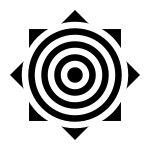

In [3]:
from IPython.display import SVG
SVG(filename="target-bw.svg")

Finally, we can also display videos:

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('dQw4w9WgXcQ', start=6, autoplay=True)

# Jupyter Quickstart

    % pip install 'ipython[all]' \
                  'numpy' \
                  'pandas' \
                  'scipy' \
                  'seaborn'
    
    % export PYSPARK_DRIVER_PYTHON=ipython
    % export PYSPARK_DRIVER_PYTHON_OPTS=notebook

# Um, Where's the Big Data?

 - Because we can evaluate code, we can also evaluate Spark jobs.
 - Coming from iPython, there’s rich support for visualisations and statistics.

## Looking into Stack Overflow

 - The Stack Exchange Network regularly publishes a dump of all their network content.
 - We can load this data into Hadoop.
 - From Jupyter, we can use Spark to explore it and perform various analysis.

# Our Cluster For Today

![15-node Hadoop Cluster](cluster.png)

## Stack Exchange with Spark (Python)

We start off with some boilerplate to import packages and set up the notebook environment.
Note that when launched via `pyspark`, the Spark Context has already been created for us.

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high-res output

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from xmltodict import parse as parse_xml
from pyspark.sql import SQLContext, Row
from pyspark.mllib.stat import Statistics

from pylab import rcParams
rcParams['figure.figsize'] = 17, 8

sql = SQLContext(sc)

(sc.version, sc.master, sc.defaultParallelism)

(u'1.3.0', u'yarn-client', 64)

## Phase 1: Initial Exploration

Time to load some data.

We'll start off with the posts from the _Travel_ Stack Exchange site, which is a fairly small dataset that we can use for exploring and building our algorithms.

This is available as XML.

In [5]:
rows = sc.textFile("/stackexchange/travel.stackexchange.com/Posts.xml*") \
         .filter(lambda line: line.lstrip().startswith("<row")) \
         .map(parse_xml)

What does the data look like?

In [6]:
row = rows.take(1)[0]
row

OrderedDict([(u'row', OrderedDict([(u'@Id', u'1'), (u'@PostTypeId', u'1'), (u'@AcceptedAnswerId', u'393'), (u'@CreationDate', u'2011-06-21T20:19:34.730'), (u'@Score', u'8'), (u'@ViewCount', u'323'), (u'@Body', u"<p>My fianc\xe9e and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?</p>\n\n<p>It seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.</p>\n\n<p><strong>EDIT</strong> We'll be travelling in 2012.</p>\n"), (u'@OwnerUserId', u'9'), (u'@LastEditorUserId', u'101'), (u'@LastEditDate', u'2011-12-28T21:36:43.910'), (u'@LastActivityDate', u'2012-05-24T14:52:14.760'), (u'@Title', u'What are some Caribbean cruises for October?'), (u'@Tags', u'<caribbean><cruising><vacation>'), (u'@AnswerCount', u'4'), (u'@CommentCount', u'4'), (u'@FavoriteCount', u'1'), (u'@ClosedDate', u'2013-02-25T23:52:47.953')]))])

In [7]:
posts = rows.map(lambda row: {
            key.lstrip('@'): value 
            for key, value in row['row'].items() 
            if key.startswith('@')
    })
post = posts.take(1)[0]
posts.count(), post

(32259,
 {u'AcceptedAnswerId': u'393',
  u'AnswerCount': u'4',
  u'Body': u"<p>My fianc\xe9e and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?</p>\n\n<p>It seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.</p>\n\n<p><strong>EDIT</strong> We'll be travelling in 2012.</p>\n",
  u'ClosedDate': u'2013-02-25T23:52:47.953',
  u'CommentCount': u'4',
  u'CreationDate': u'2011-06-21T20:19:34.730',
  u'FavoriteCount': u'1',
  u'Id': u'1',
  u'LastActivityDate': u'2012-05-24T14:52:14.760',
  u'LastEditDate': u'2011-12-28T21:36:43.910',
  u'LastEditorUserId': u'101',
  u'OwnerUserId': u'9',
  u'PostTypeId': u'1',
  u'Score': u'8',
  u'Tags': u'<caribbean><cruising><vacation>',
  u'Title': u'What are some Caribbean cruises for October?',
  u'ViewCount': u'323'})

Posts are either questions or answers, with the `PostTypeId` attribute used to discriminate.

In [8]:
questions = posts.filter(lambda post: post['PostTypeId'] == '1')
answers = posts.filter(lambda post: post['PostTypeId'] == '2')

In [9]:
qCount, aCount, pCount = questions.count(), answers.count(), posts.count()
qCount, aCount, pCount

(10509, 18991, 32259)

In [10]:
qCount + aCount == pCount

False

Hmm. Things don't seem to add up. So let's see what's going on…

In [11]:
typeCounts = posts.map(lambda post: post['PostTypeId']) \
                  .countByValue()
typeCounts

defaultdict(<type 'int'>, {u'1': 10509, u'2': 18991, u'5': 1375, u'4': 1375, u'7': 4, u'6': 5})

In [12]:
df = pd.DataFrame(typeCounts.items(), columns=['type', 'total'])
df

,type,total
0,1,10509
1,2,18991
2,5,1375
3,4,1375
4,7,4
5,6,5


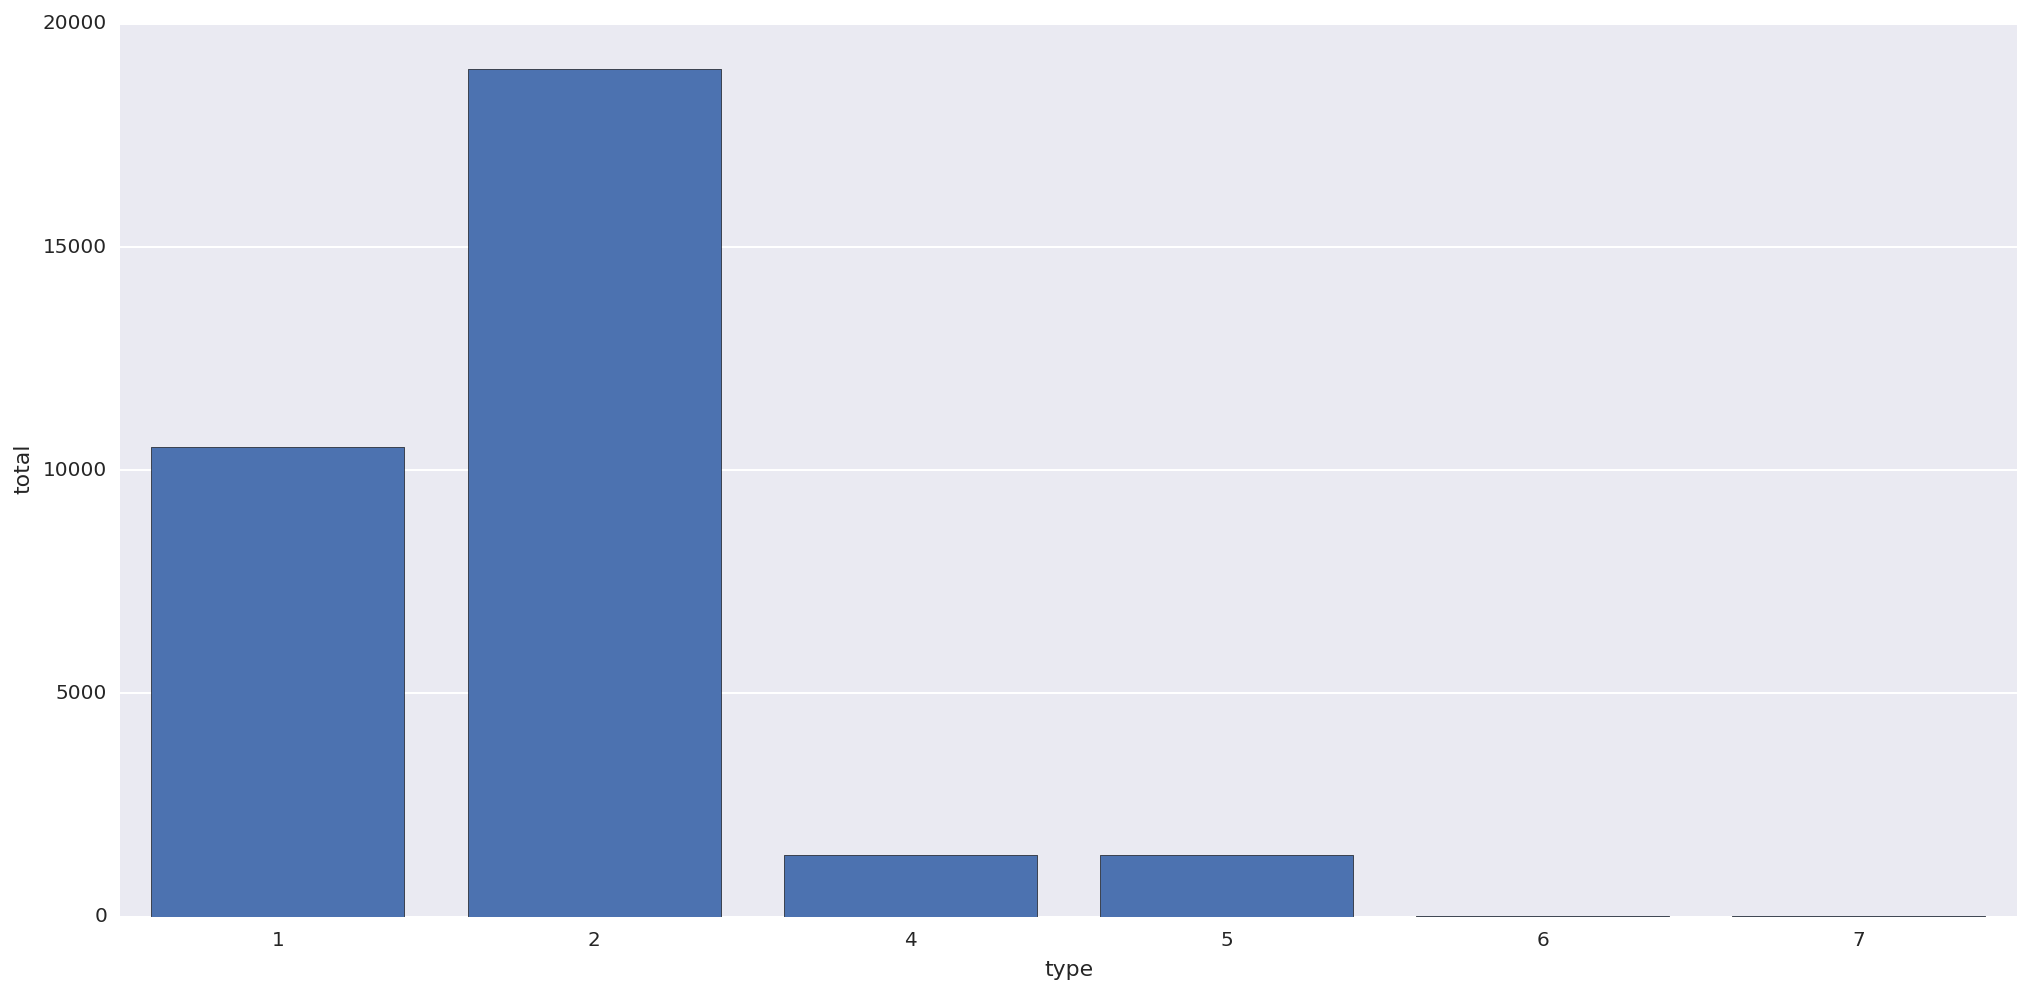

In [13]:
sns.barplot(x = df.type, y = df.total);

Okay, so most of the data is either a post or an answer. There's some other stuff in there, which we could (and should!) check out, but in the interests of keeping this brief we can just ignore it.

We've also noticed that things are quite slow. It turns out most of our time is spent parsing XML. With this dataset we can simply cache the results, but as we head to bigger datasets we're going to run into trouble.

To deal with this, I've [converted the data into Parquet files](https://github.com/godatadriven/stackexchange-parquet). These can be read much more efficiently, and from now on we'll use these.

So let's redefine what we have so far:

In [14]:
files = ["/stackexchange/travel.stackexchange.com/posts/part-r-%05d.parquet" % x for x in range(1,3)]
posts = sql.parquetFile(*files)
questions = posts.filter(posts.postType == 1)
answers = posts.filter(posts.postType == 2)
(questions.count(), answers.count(), posts.count())

(10509L, 18991L, 32259L)

That was quick!

So up above, we could see that there are more answers than questions. (That's a relief: this is what you want in a healthy Q&A site.) But not all questions will have answers. So before we move on, let's plot the distribution of how many answers each question has.

Finally, before we move on let's look at how many answers each question has.

In [15]:
answerCounts = questions.select('answerCount').rdd.map(lambda row: row.answerCount).countByValue()
answerCounts

defaultdict(<type 'int'>, {0: 821, 1: 4911, 2: 2616, 3: 1135, 4: 489, 5: 243, 6: 125, 7: 59, 8: 35, 9: 33, 10: 13, 11: 12, 12: 5, 13: 2, 14: 2, 16: 1, 18: 2, 19: 1, 20: 2, 21: 1, 24: 1})

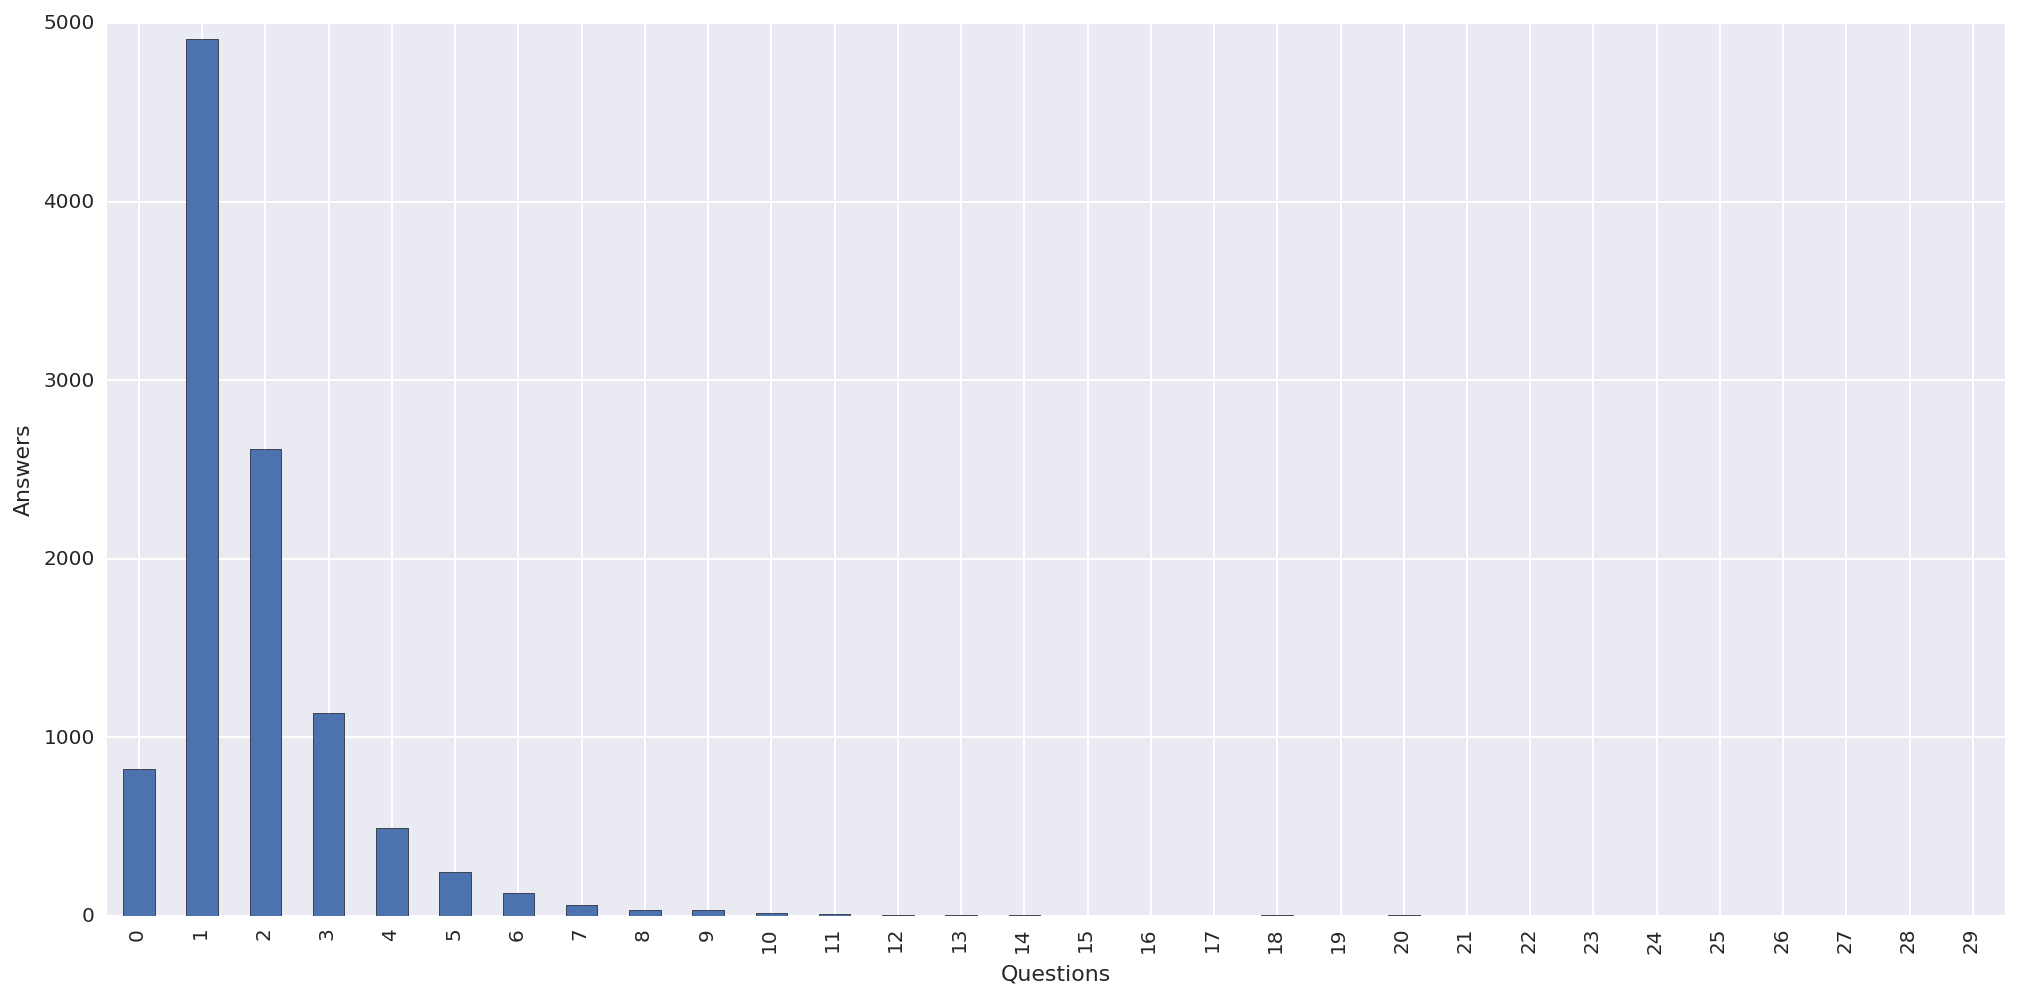

In [16]:
def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)

ax = pd.Series(answerCounts, index=np.arange(30)).fillna(0).plot(kind='bar')
labels("Questions", "Answers", ax)

## Phase 2: Let's Look At Trends

One of the things that we can look at is the site growth over time. Normal web analytics looks into things like page views, but often there's a domain-specific measure of vitality. For a Stack Exchange site, the number of new questions being posed is probably a good place to start so let's check that out.

In [17]:
askedTimestamps = questions.select("created")
askedByMonth = askedTimestamps.rdd.map(lambda row: row.created.date().replace(day=1)).countByValue()
askedByMonth = pd.Series(askedByMonth)

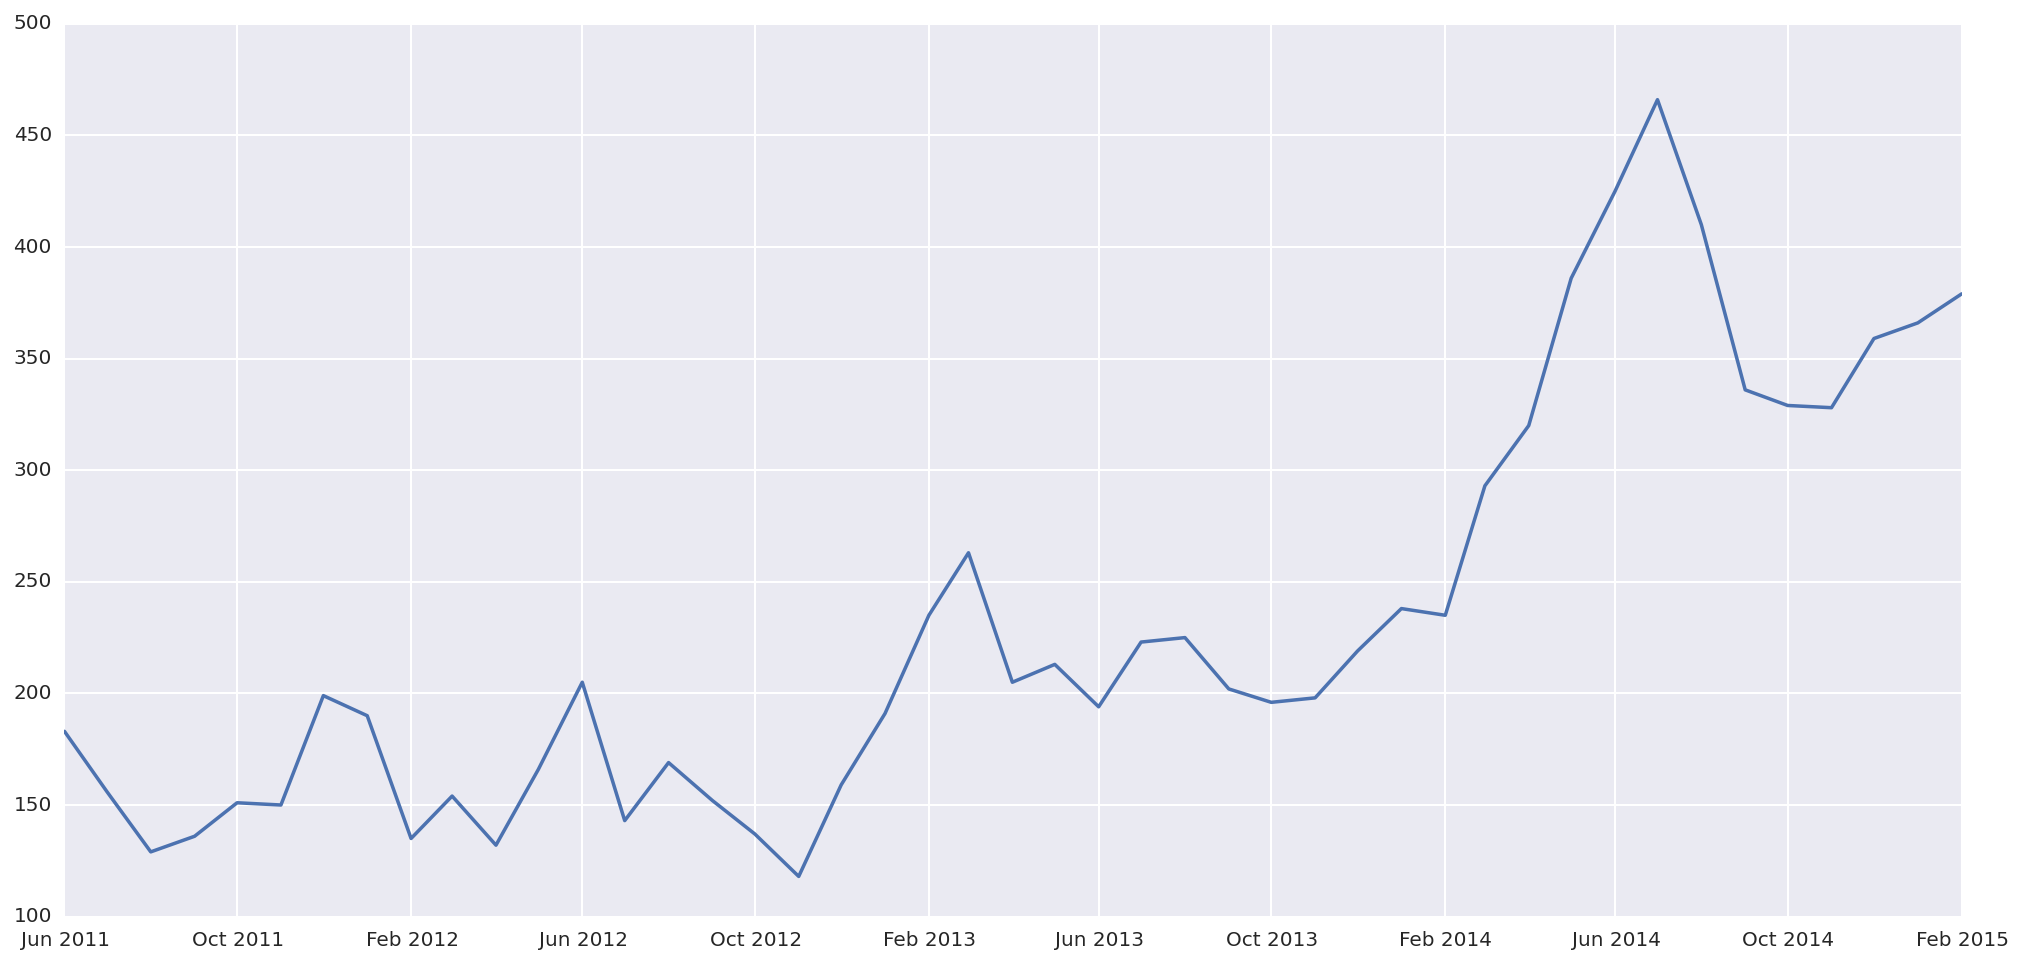

In [18]:
askedByMonth[:-1].plot();

Okay, so it looks like there's extra demand in July. For a travel site, I wonder why…

How about we look at the day of the week?

In [19]:
askedByDoW = askedTimestamps.map(lambda row: row.created.isoweekday()).countByValue()
askedByDoW = pd.Series(askedByDoW)

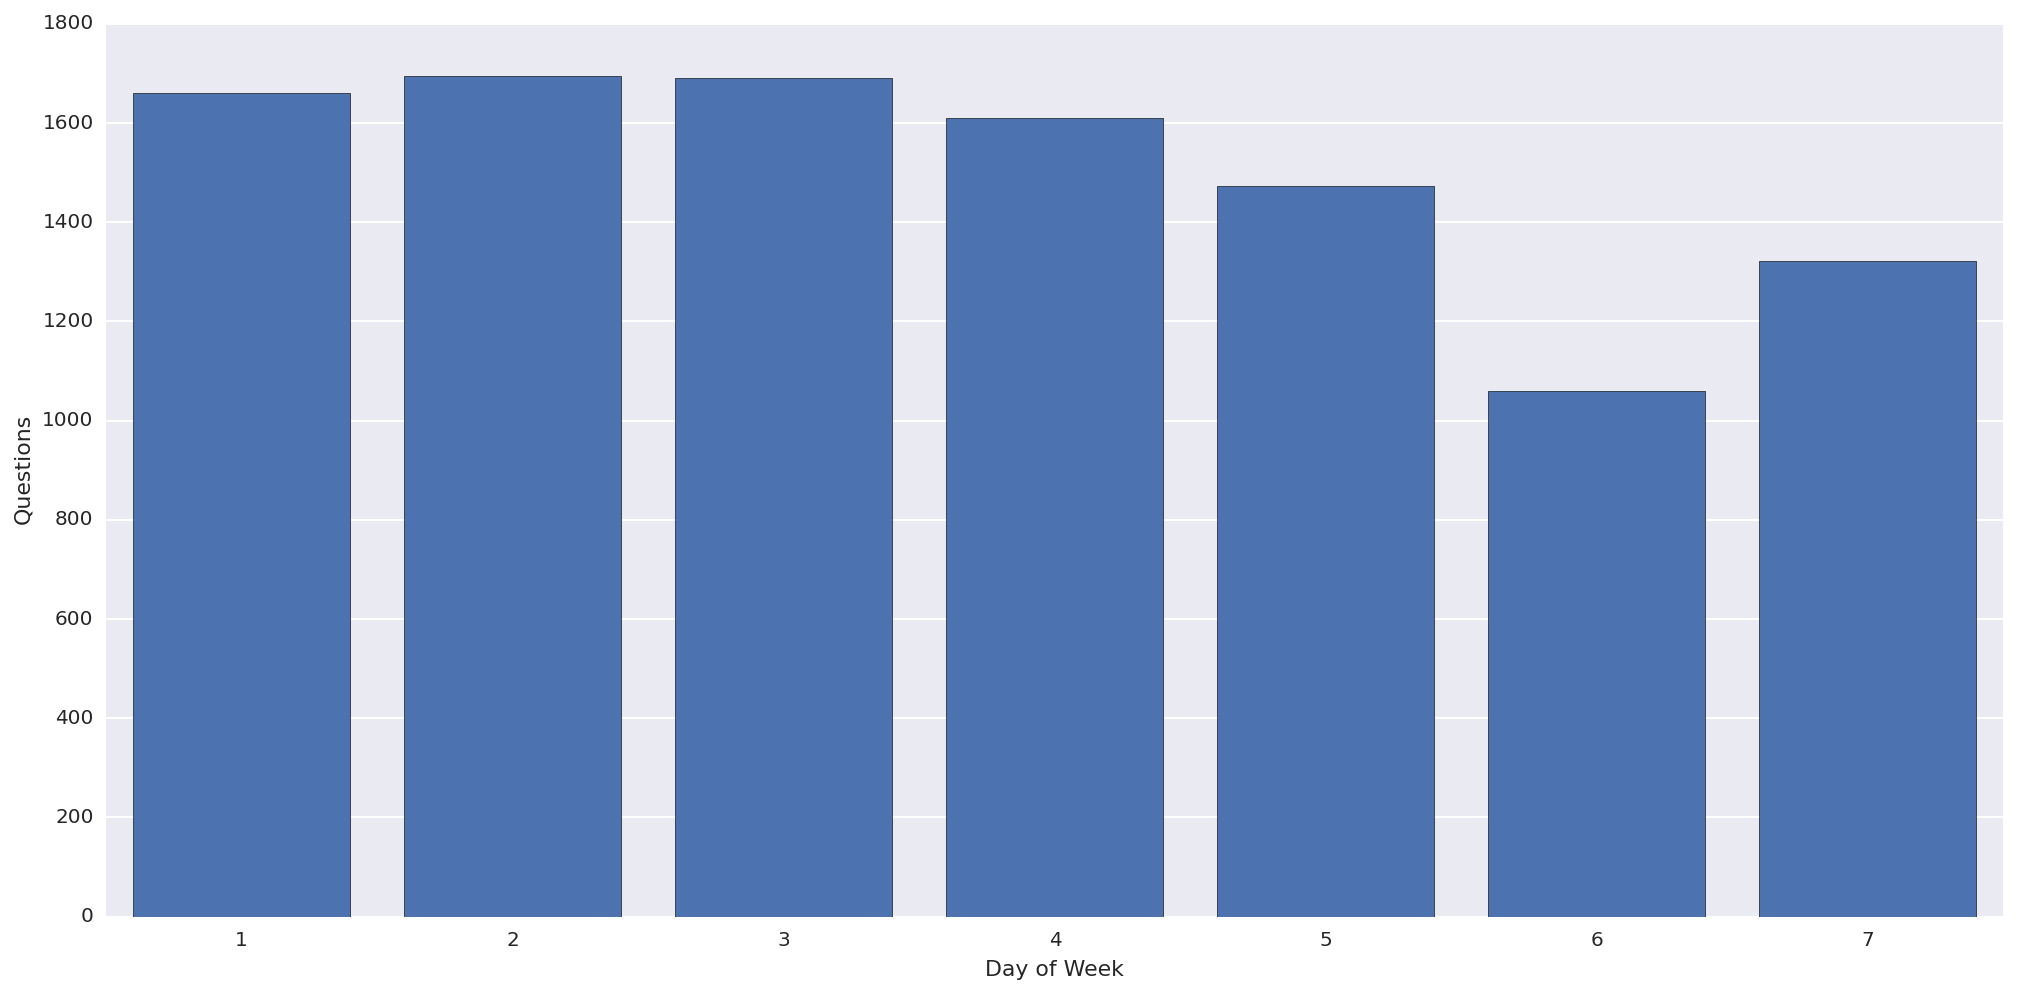

In [20]:
ax = sns.barplot(askedByDoW.index, y=askedByDoW)
labels("Day of Week", "Questions", ax)

(1 is Monday, 2 is Tuesday, etc.)

Now let's have a look at the day of week, instead indexed by the probability that the question was answered.

In [21]:
closedByDoW = questions.filter("closed is not null") \
                       .select("closed") \
                       .map(lambda row: row.closed.isoweekday ()) \
                       .countByValue()
closedByDoW = pd.Series(closedByDoW)

In [22]:
questionsByDoW = pd.DataFrame({"asked": askedByDoW, "closed": closedByDoW})
questionsByDoW

,asked,closed
1,1660,284
2,1695,300
3,1690,283
4,1611,225
5,1473,221
6,1059,126
7,1321,171


In [23]:
questionsByDoW["pSuccess"] = questionsByDoW["closed"] / questionsByDoW["asked"]
questionsByDoW

,asked,closed,pSuccess
1,1660,284,0.171084
2,1695,300,0.176991
3,1690,283,0.167456
4,1611,225,0.139665
5,1473,221,0.150034
6,1059,126,0.118980
7,1321,171,0.129447


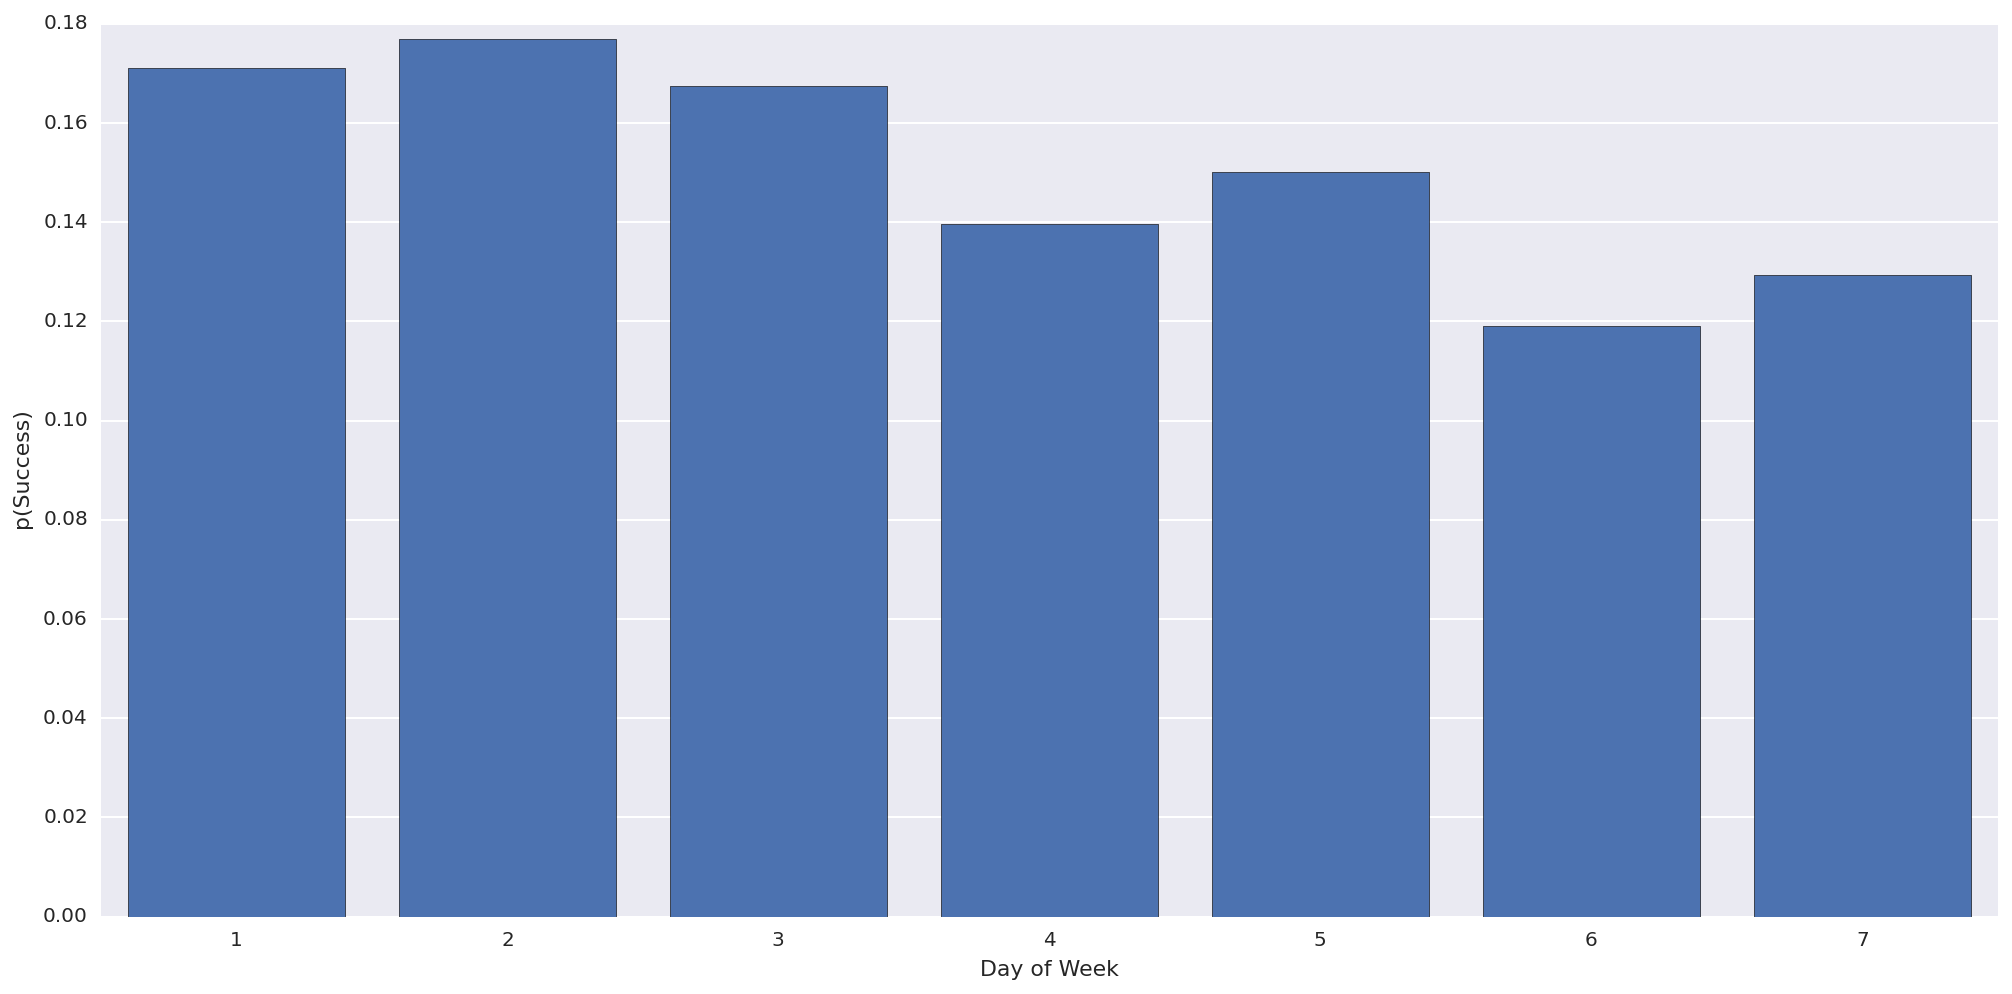

In [24]:
ax = sns.barplot(questionsByDoW.index, y="pSuccess", data=questionsByDoW)
labels("Day of Week", "p(Success)", ax)

Right, so it seems that questions asked on a Tuesday are most likely to be answered. (Be careful here: we don't know _why_ they're more likely.)

However, we might not have asked the right question here. When asking a question, you normally want an answer. This means you don't only care about whether it was answered or not, but how quickly. So perhaps we should instead be looking at whether it was answered within a day…

In [25]:
quicklyByDoW = questions.filter("closed is not null") \
                        .select("created", "closed") \
                        .rdd.filter(lambda row: (row.closed - row.created).days < 1) \
                        .map(lambda row: row.created.isoweekday()) \
                        .countByValue()
questionsByDoW["quickly"] = pd.Series(quicklyByDoW)
questionsByDoW["pQuickly"] = questionsByDoW["quickly"] / questionsByDoW["asked"]
questionsByDoW

,asked,closed,pSuccess,quickly,pQuickly
1,1660,284,0.171084,179,0.107831
2,1695,300,0.176991,234,0.138053
3,1690,283,0.167456,196,0.115976
4,1611,225,0.139665,151,0.093731
5,1473,221,0.150034,146,0.099117
6,1059,126,0.118980,87,0.082153
7,1321,171,0.129447,112,0.084784


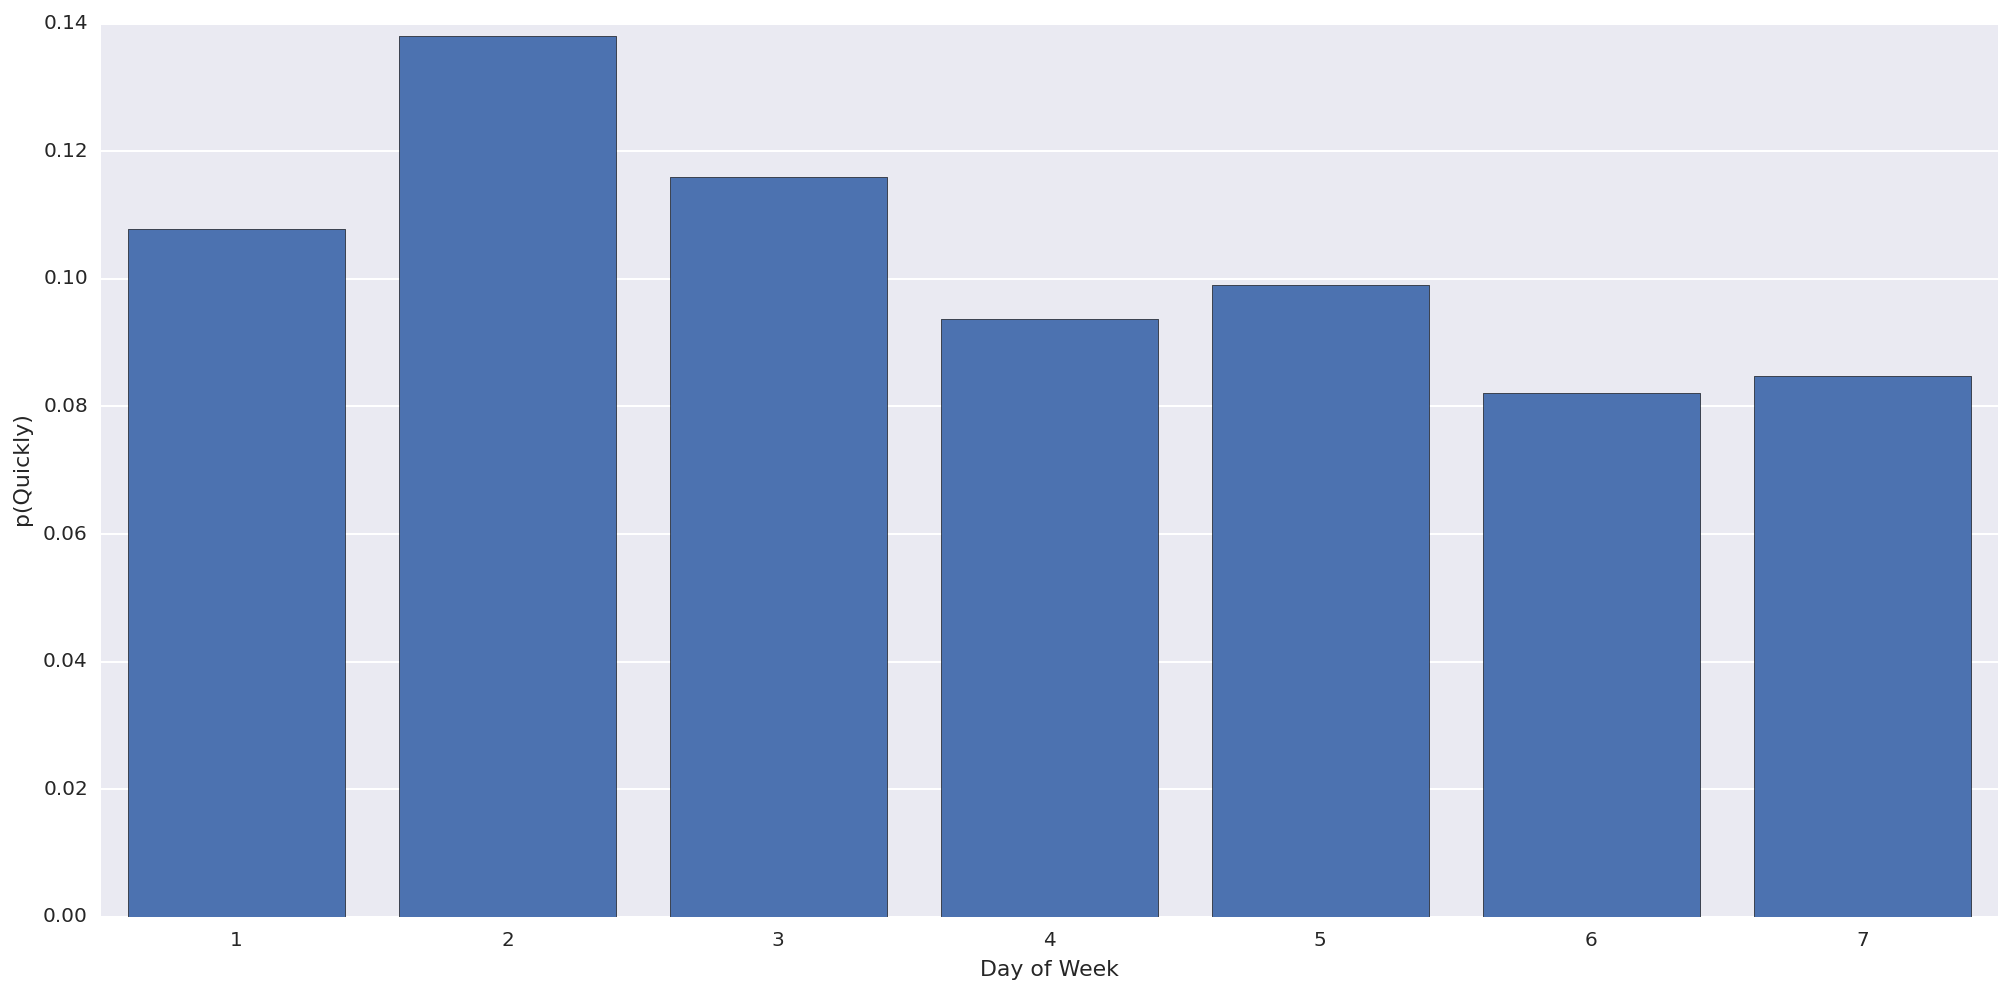

In [26]:
ax = sns.barplot(questionsByDoW.index, y="pQuickly", data=questionsByDoW)
labels("Day of Week", "p(Quickly)", ax)

So, questions on a Tuesday have the highest probability of being answered within a day.

So all this talk of answering questions quickly makes me wonder what the overall distribution looks like.

In [27]:
closeDelay = questions.filter('closed is not null') \
                      .select("created", "closed") \
                      .rdd.map(lambda row: (row.closed - row.created).seconds / 3600.00) \
                      .collect()

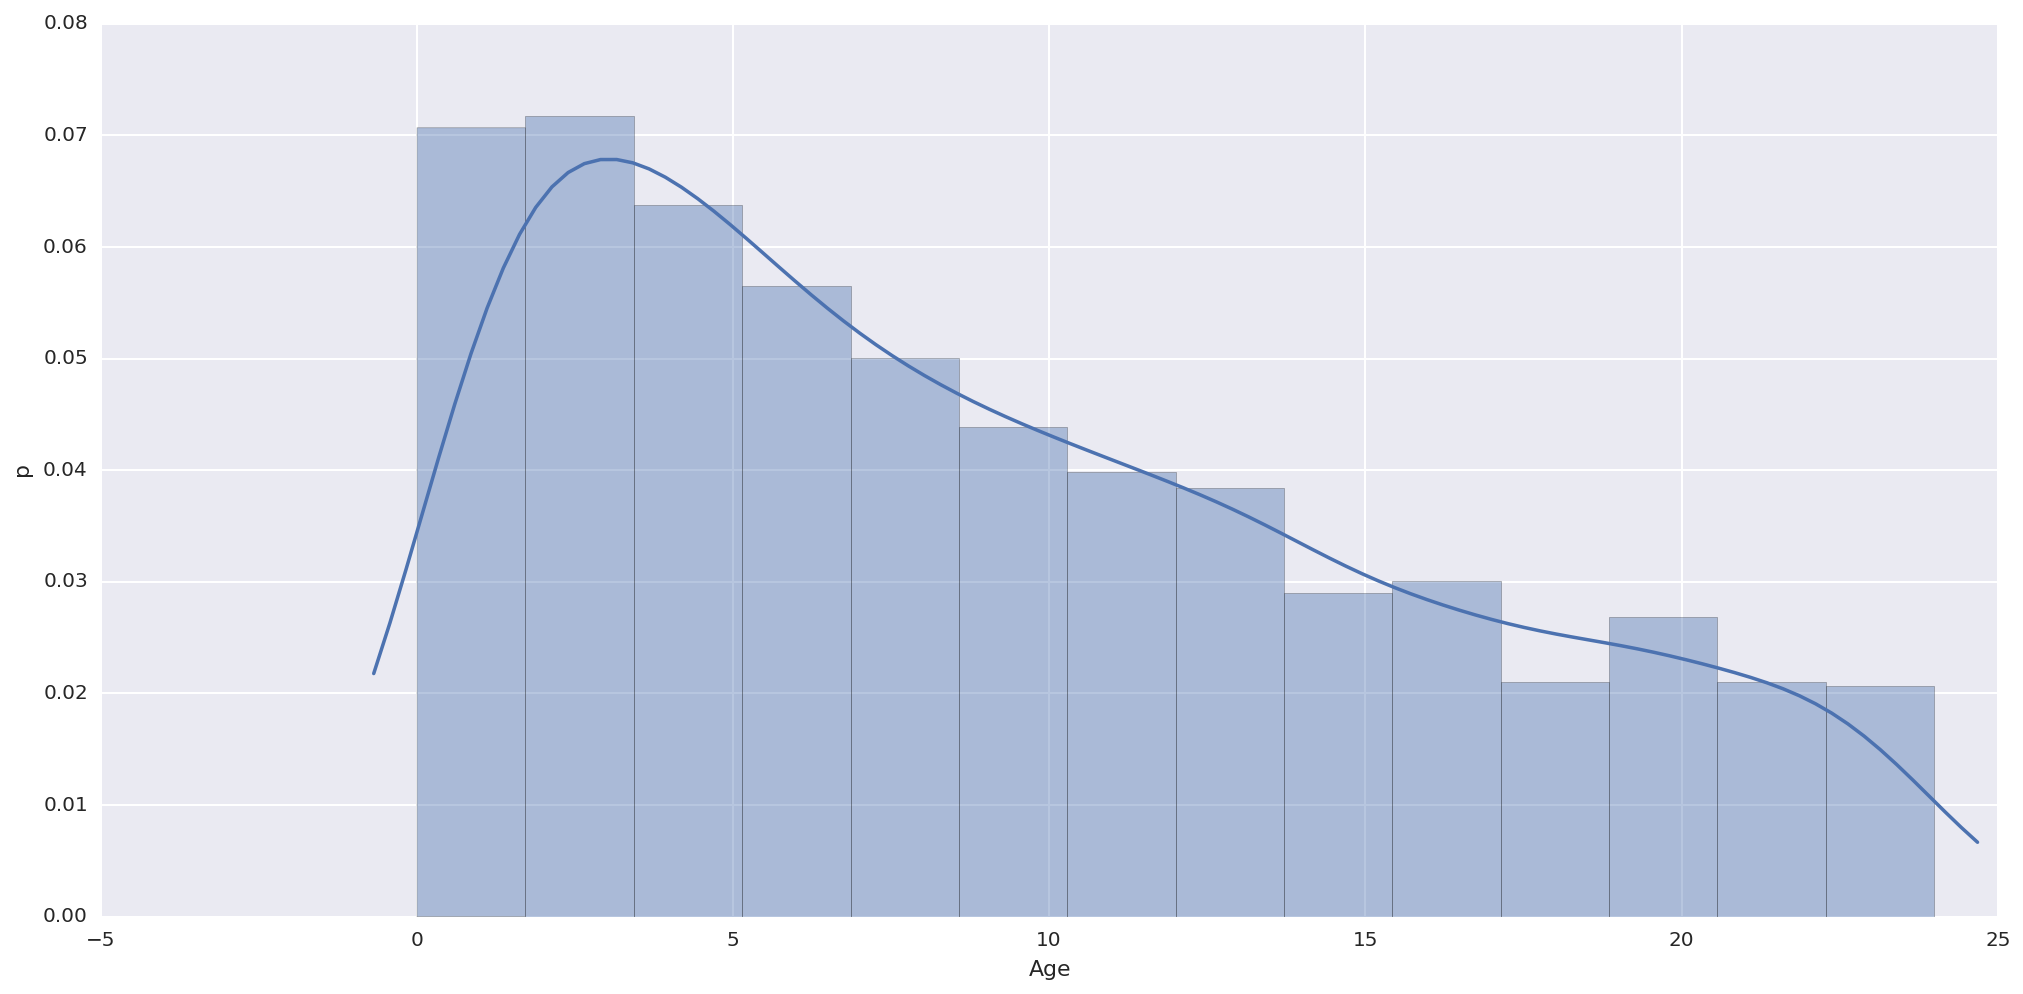

In [28]:
ax = sns.distplot(closeDelay)
labels("Age", "p", ax)

Huh? Everything is closed within a day?

Ahh. We made a mistake; the seconds attribute isn't the total number of seconds, it's just the seconds component of the time difference, which is composed of days, seconds and milliseconds.

So let's fix that: it turns out there's a `total_seconds()` method which does what we want.

In [29]:
closeDelay = questions.filter('closed is not null') \
                      .select("created", "closed") \
                      .rdd.map(lambda row: (row.closed - row.created).total_seconds() / 3600.00) \
                      .collect()

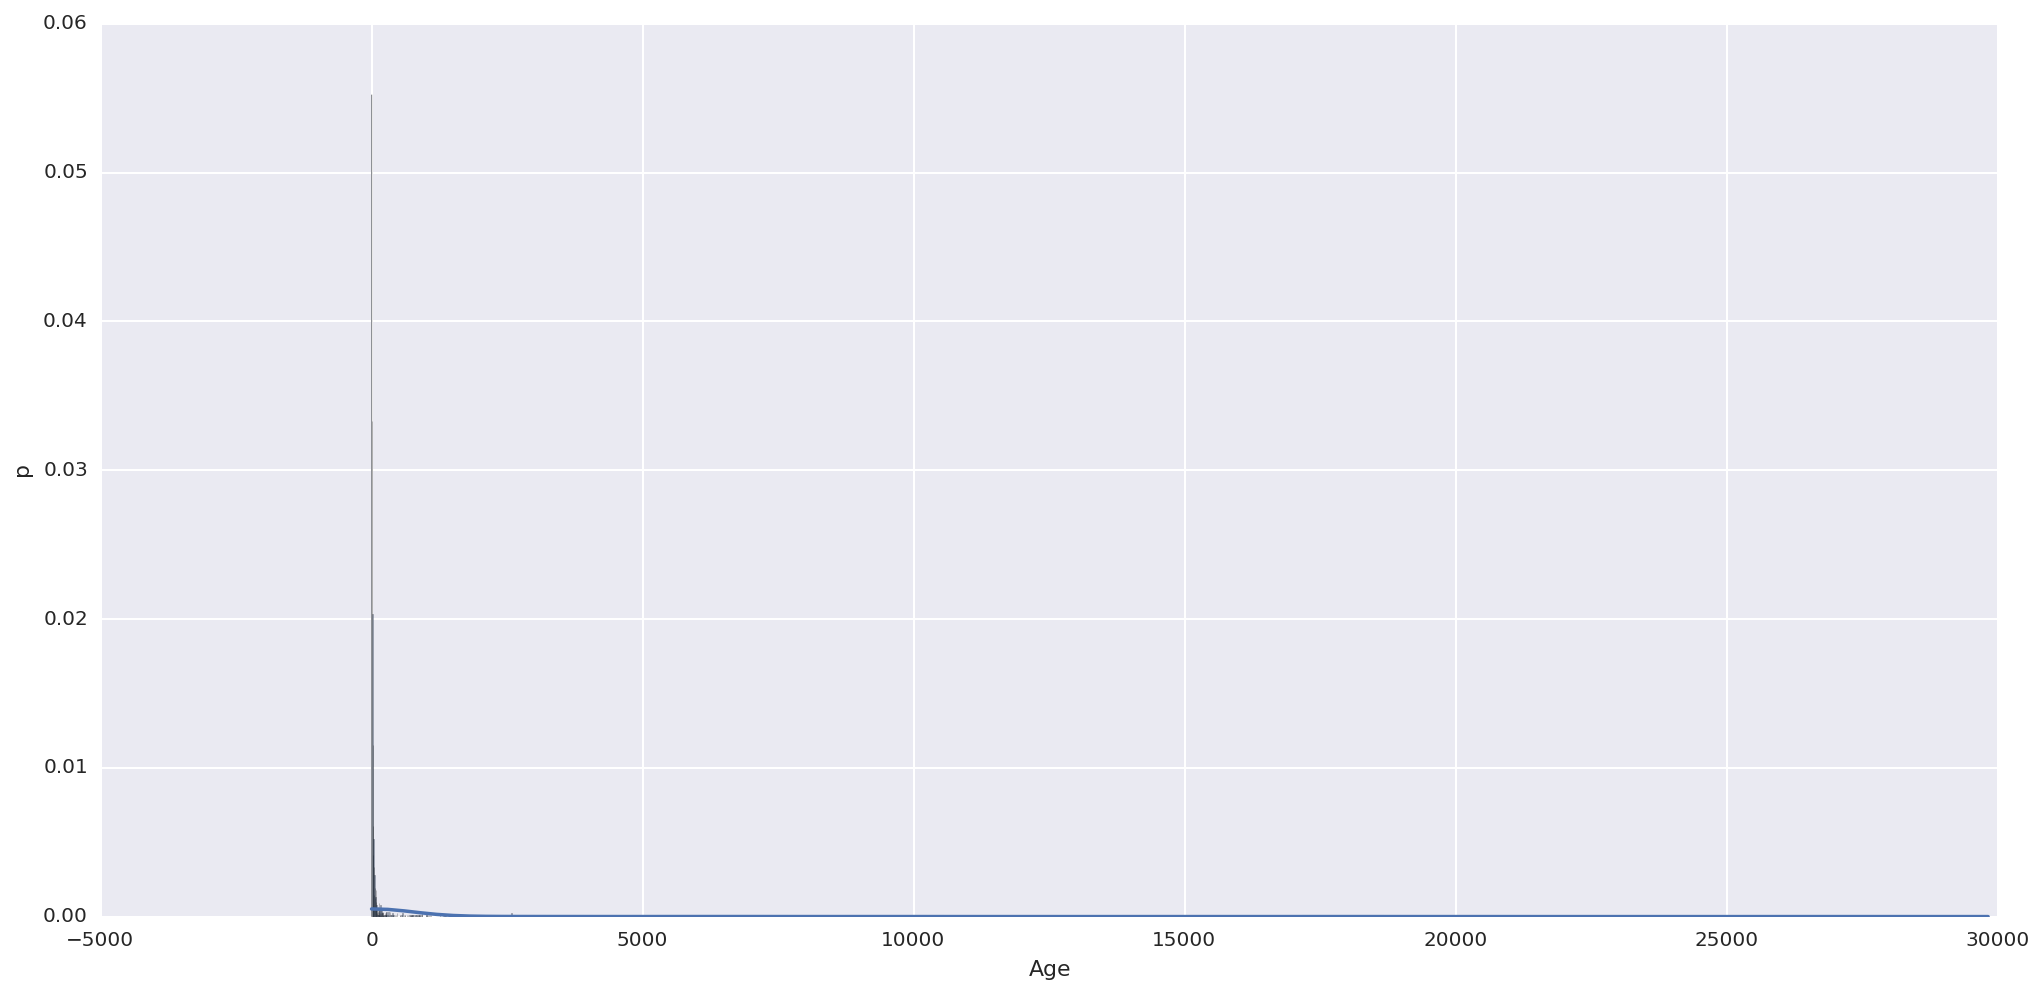

In [30]:
ax = sns.distplot(closeDelay)
labels("Age", "p", ax)

That's not very interesting to look at. So let's just look at the first week…

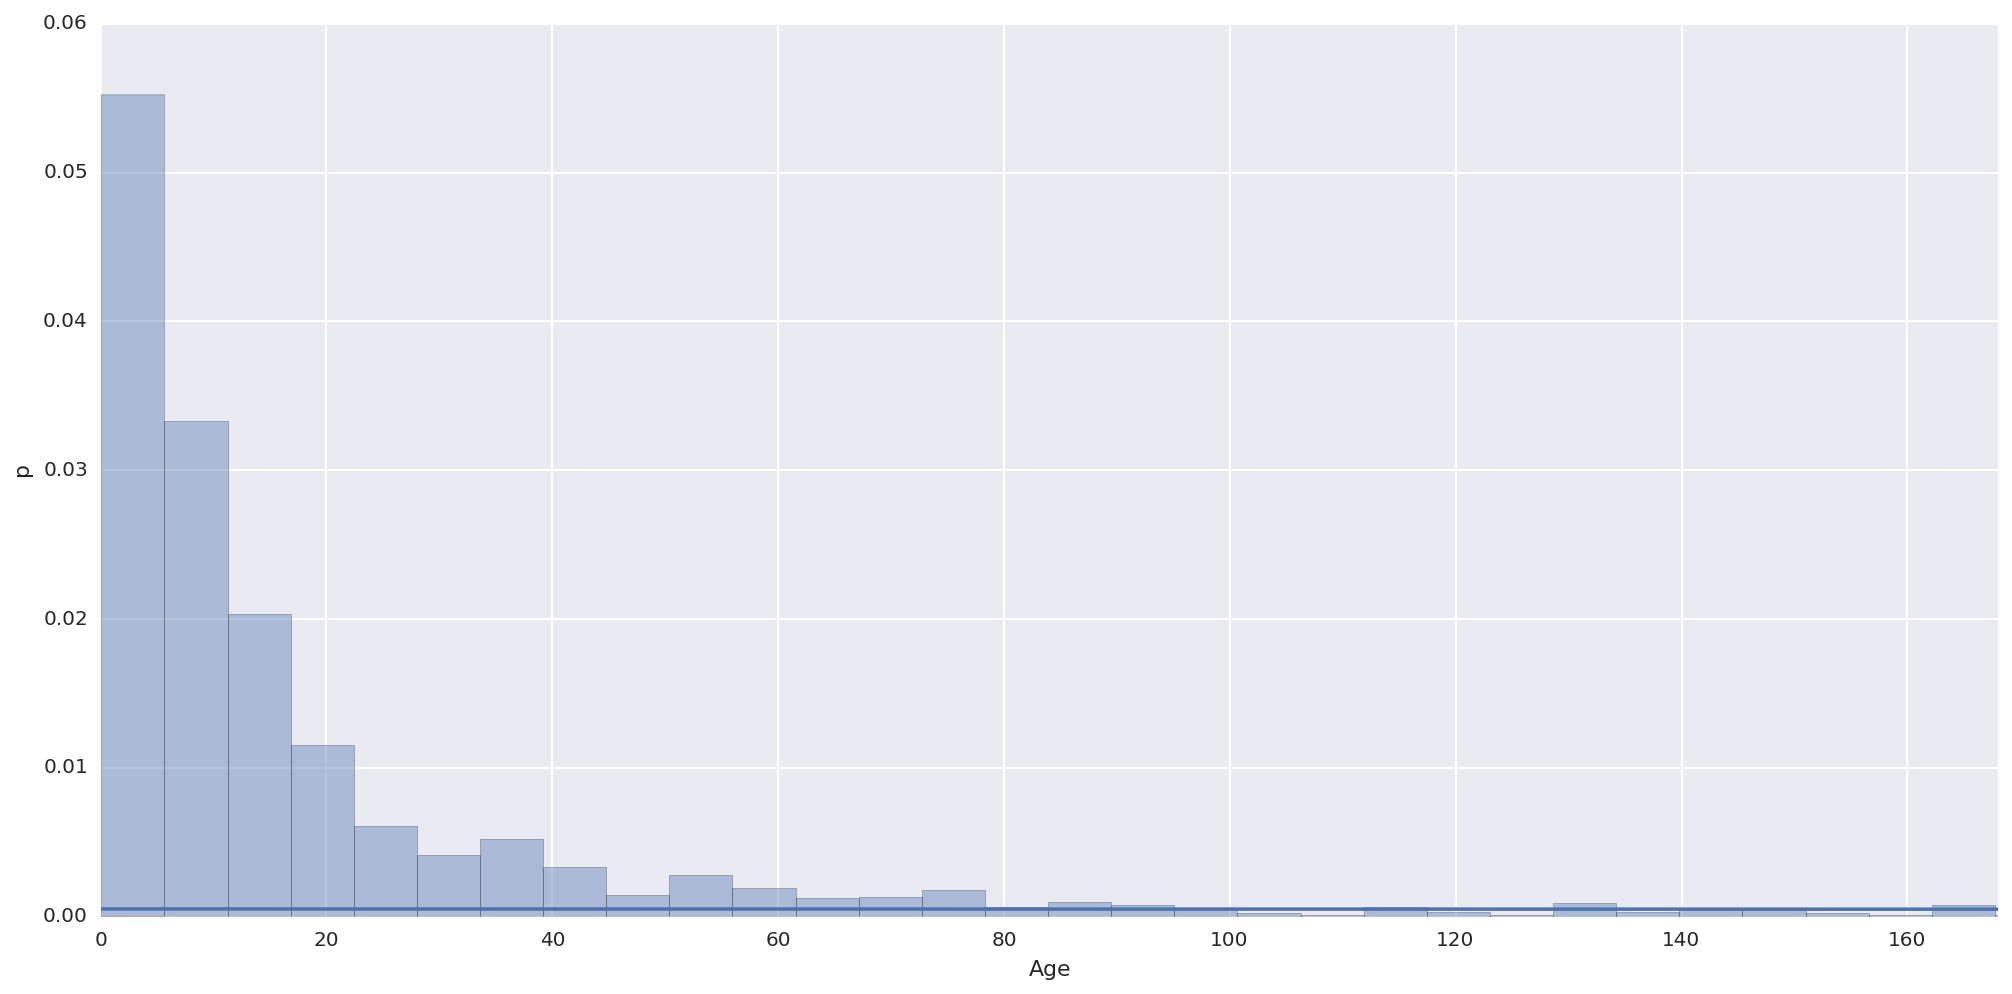

In [31]:
delayplot = sns.distplot(closeDelay)
delayplot.axes.set_xlim(0,7*24)
labels("Age", "p", delayplot)

## Phase 3: Further Exploration

Let's look for some basic relationships, like how the counts on a question might be related. We start off doing this visually on a sample of the data.

When working visually, it's often a good idea to take a random sample to avoid being swamped with data.

In [32]:
questionCounts = questions.select('id','answerCount','commentCount','favoriteCount','score','viewCount')
questionCounts.show()

id answerCount commentCount favoriteCount score viewCount
1  4           4            1             8     323      
2  7           4            4             24    829      
4  1           1            null          8     213      
5  5           0            2             11    300      
6  6           9            17            66    2626     
8  3           2            null          9     6266     
9  4           1            8             12    1281     
10 19          11           25            91    7705     
11 3           1            3             21    1126     
13 2           4            null          7     315      
14 3           3            null          6     293      
15 2           2            2             9     206      
16 11          1            28            52    2535     
25 7           3            15            39    1888     
26 4           3            10            31    1781     
27 14          0            8             24    464      
28 3          

In [33]:
fraction = 1000.0 / questionCounts.count()
pf = questionCounts.sample(fraction=fraction, withReplacement=False, seed=123456).toPandas()

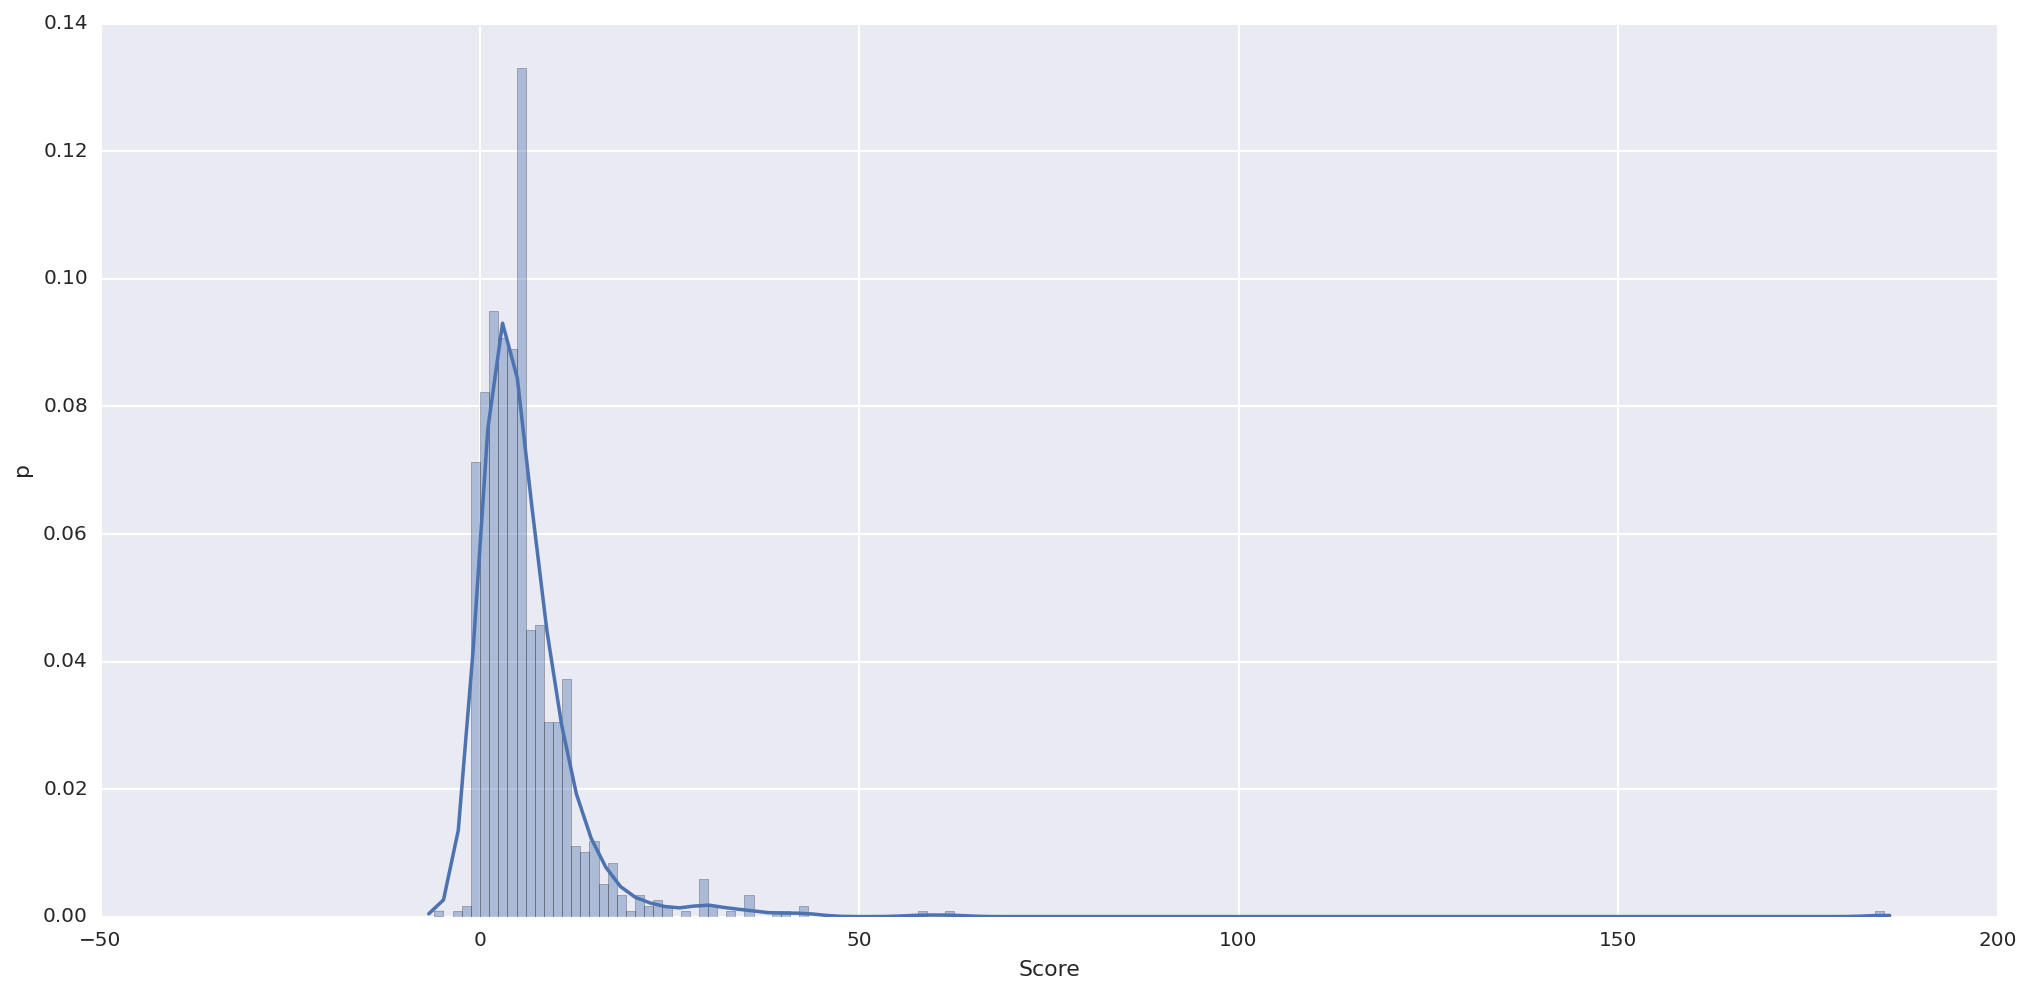

In [34]:
ax = sns.distplot(pf[["score"]])
labels("Score", "p", ax)

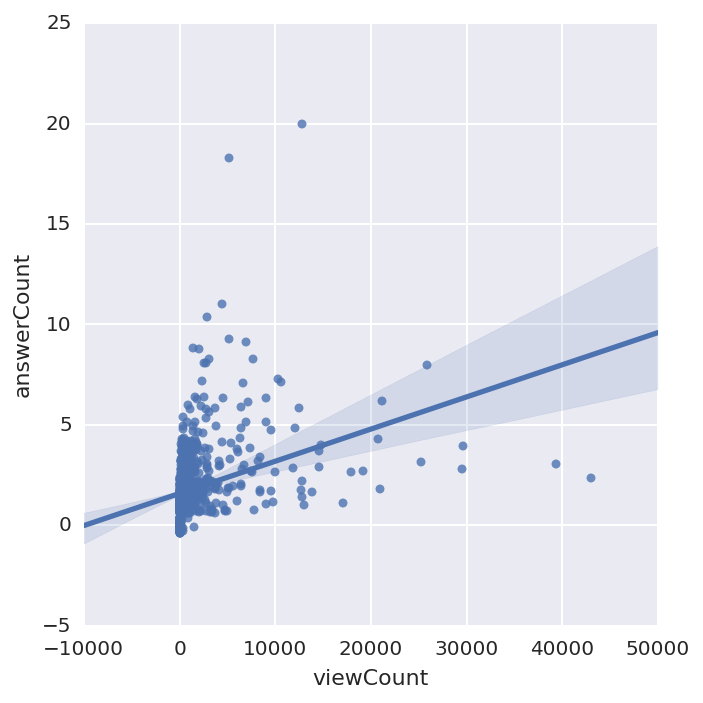

In [35]:
sns.lmplot(x="viewCount", y="answerCount", data=pf, y_jitter=0.4);

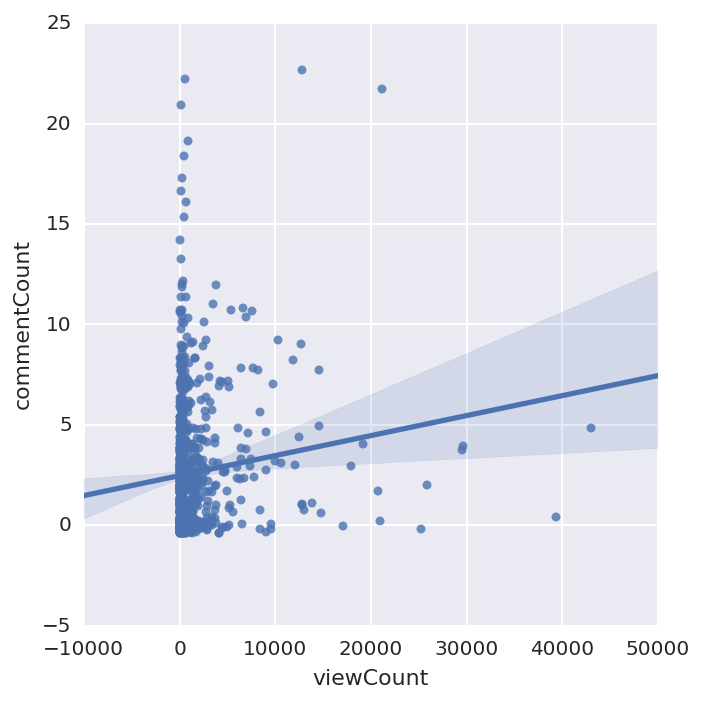

In [36]:
sns.lmplot(x='viewCount', y='commentCount', data=pf, y_jitter=0.4);

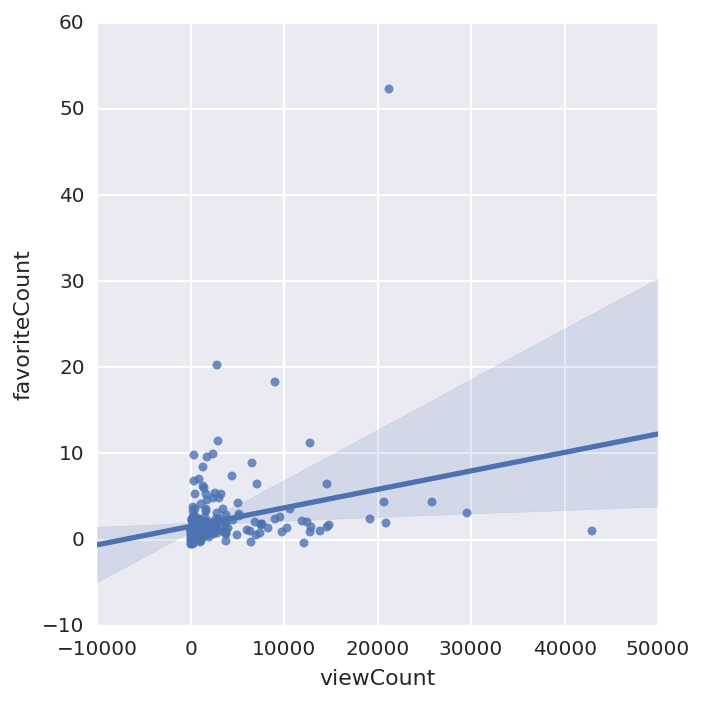

In [37]:
sns.lmplot(x='viewCount',y='favoriteCount', data=pf, y_jitter=0.5);

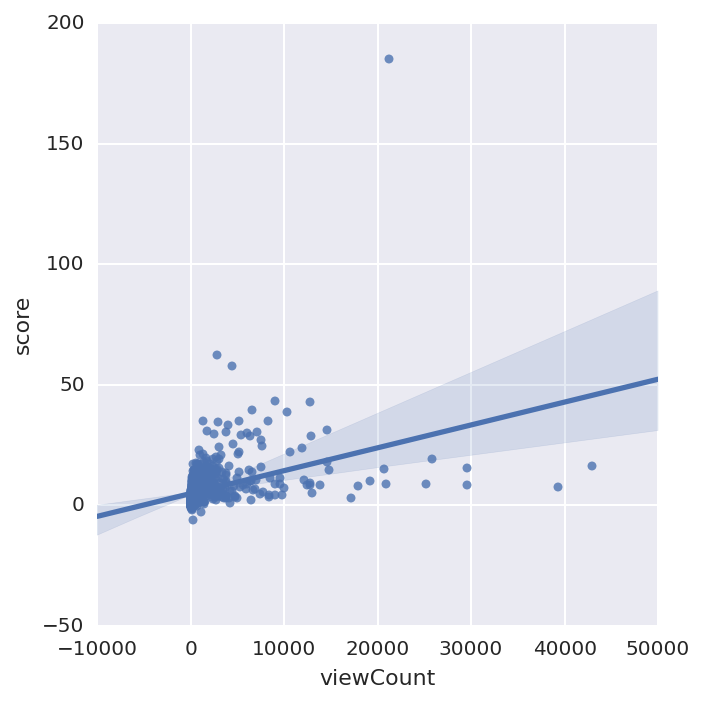

In [38]:
sns.lmplot(x='viewCount', y='score', data=pf, y_jitter=0.4);

We're not really getting anywhere here; there's no clear trend yet. We've been assuming the _View Count_ will be a reasonable predictor of something, but this was probably wrong.

Maybe there's something else instead? Let's display the complete correlation table, and see if it yields anything.

In [39]:
pf_corr = pf.corr(method='pearson')
pf_corr

,id,answerCount,commentCount,favoriteCount,score,viewCount
id,1.000000,-0.225326,0.064519,-0.019644,-0.220372,-0.206540
answerCount,-0.225326,1.000000,0.196370,0.358044,0.530474,0.345222
commentCount,0.064519,0.196370,1.000000,0.346954,0.259946,0.112676
favoriteCount,-0.019644,0.358044,0.346954,1.000000,0.864298,0.277501
score,-0.220372,0.530474,0.259946,0.864298,1.000000,0.391414
viewCount,-0.206540,0.345222,0.112676,0.277501,0.391414,1.000000


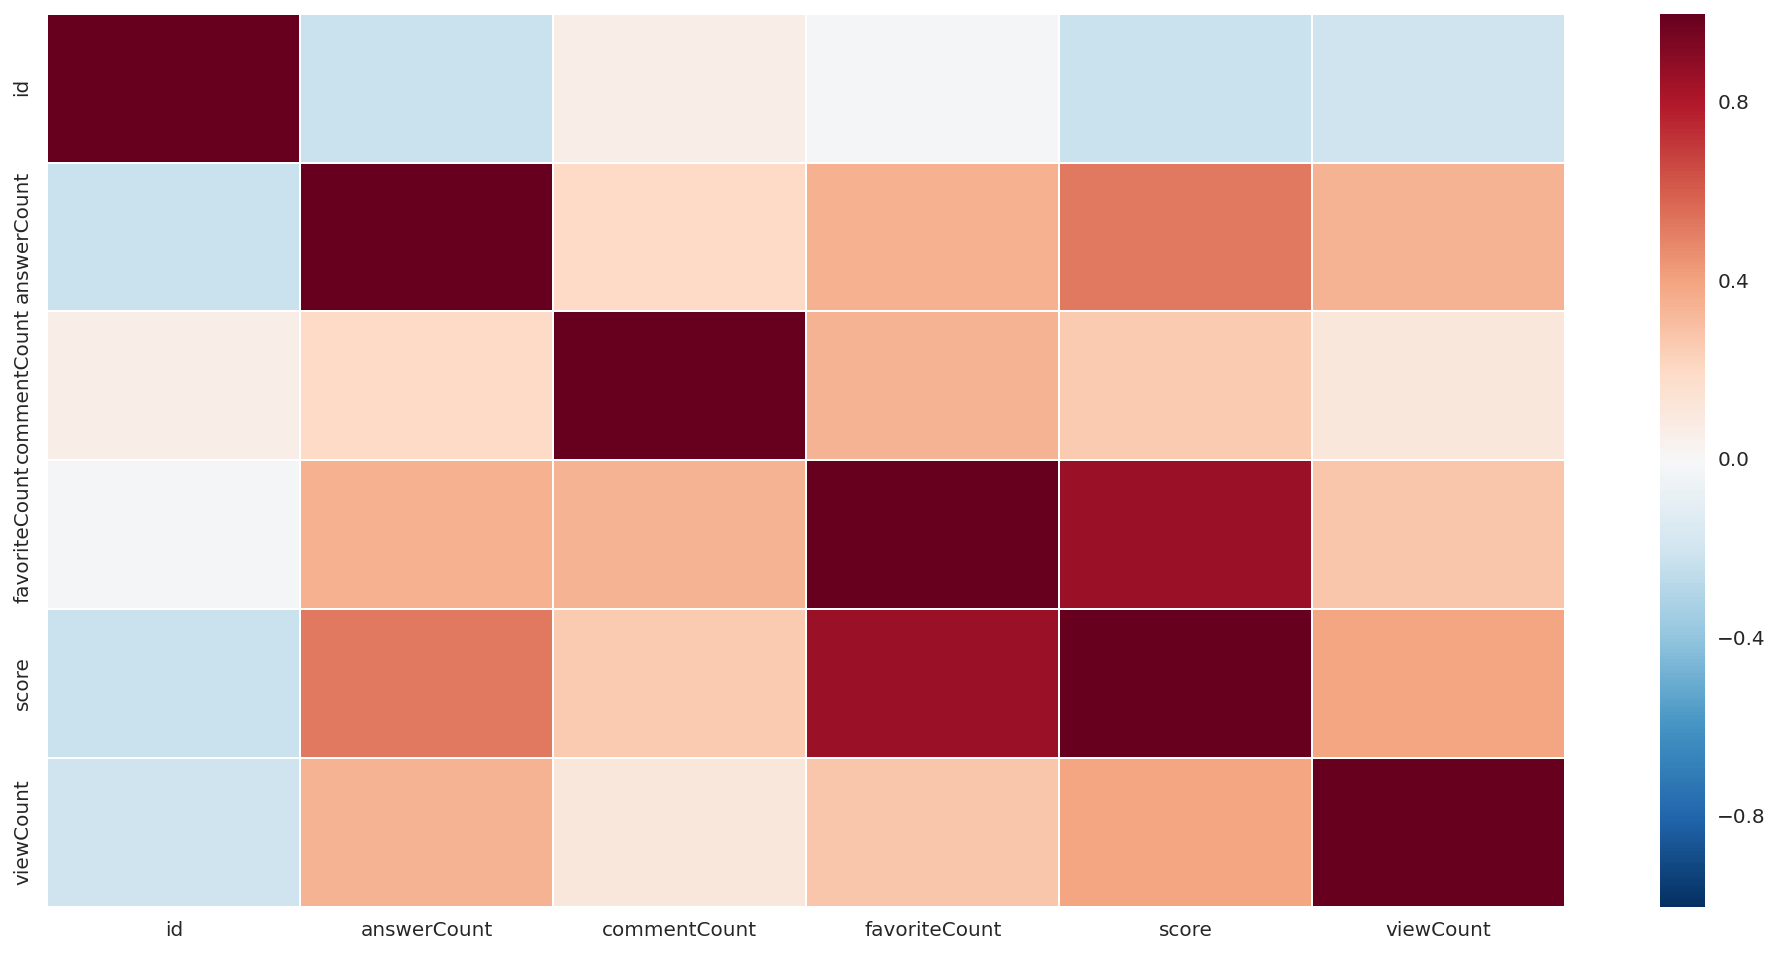

In [40]:
sns.heatmap(pf_corr);

So, it seems here that the strongest correlation is between the _Score_ and _Favorite Count_. That kind of makes sense…

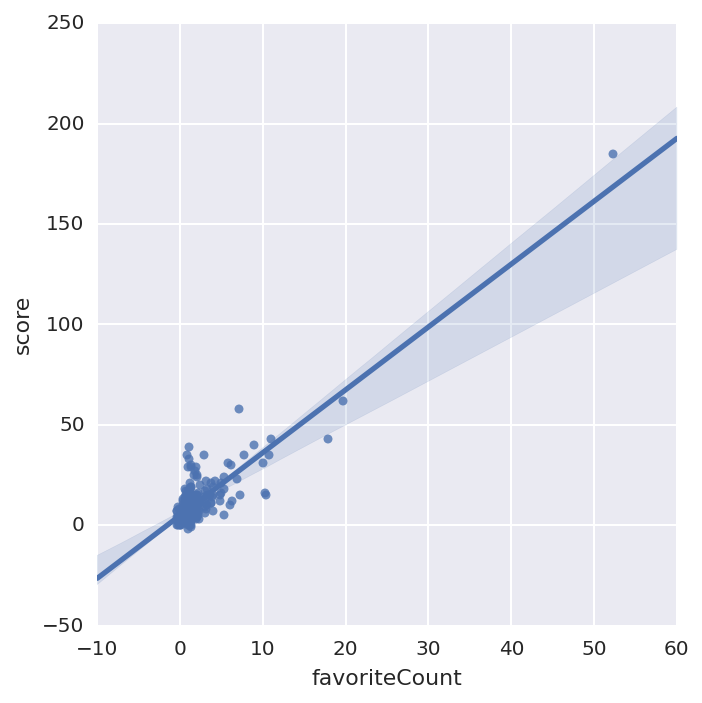

In [41]:
sns.lmplot(x='favoriteCount',y='score', data=pf, x_jitter=0.4);

This was only done on a sample of the data. With Spark's Machine Learning library, we can calculate the correlation matrix over the complete set of data.

In [42]:
sp_corr = Statistics.corr(questionCounts.rdd.map(lambda row: [row.id,
                                                              row.answerCount,
                                                              row.commentCount,
                                                              row.favoriteCount if row.favoriteCount is not None else 0,
                                                              row.score,
                                                              row.viewCount]))
sp_corr

array([[ 1.        , -0.25524095,  0.07765338, -0.16204452, -0.27043911,
        -0.18204635],
       [-0.25524095,  1.        ,  0.15121571,  0.44833384,  0.55756217,
         0.30412184],
       [ 0.07765338,  0.15121571,  1.        ,  0.17297529,  0.20308963,
         0.07458114],
       [-0.16204452,  0.44833384,  0.17297529,  1.        ,  0.73854474,
         0.30911342],
       [-0.27043911,  0.55756217,  0.20308963,  0.73854474,  1.        ,
         0.4162931 ],
       [-0.18204635,  0.30412184,  0.07458114,  0.30911342,  0.4162931 ,
         1.        ]])

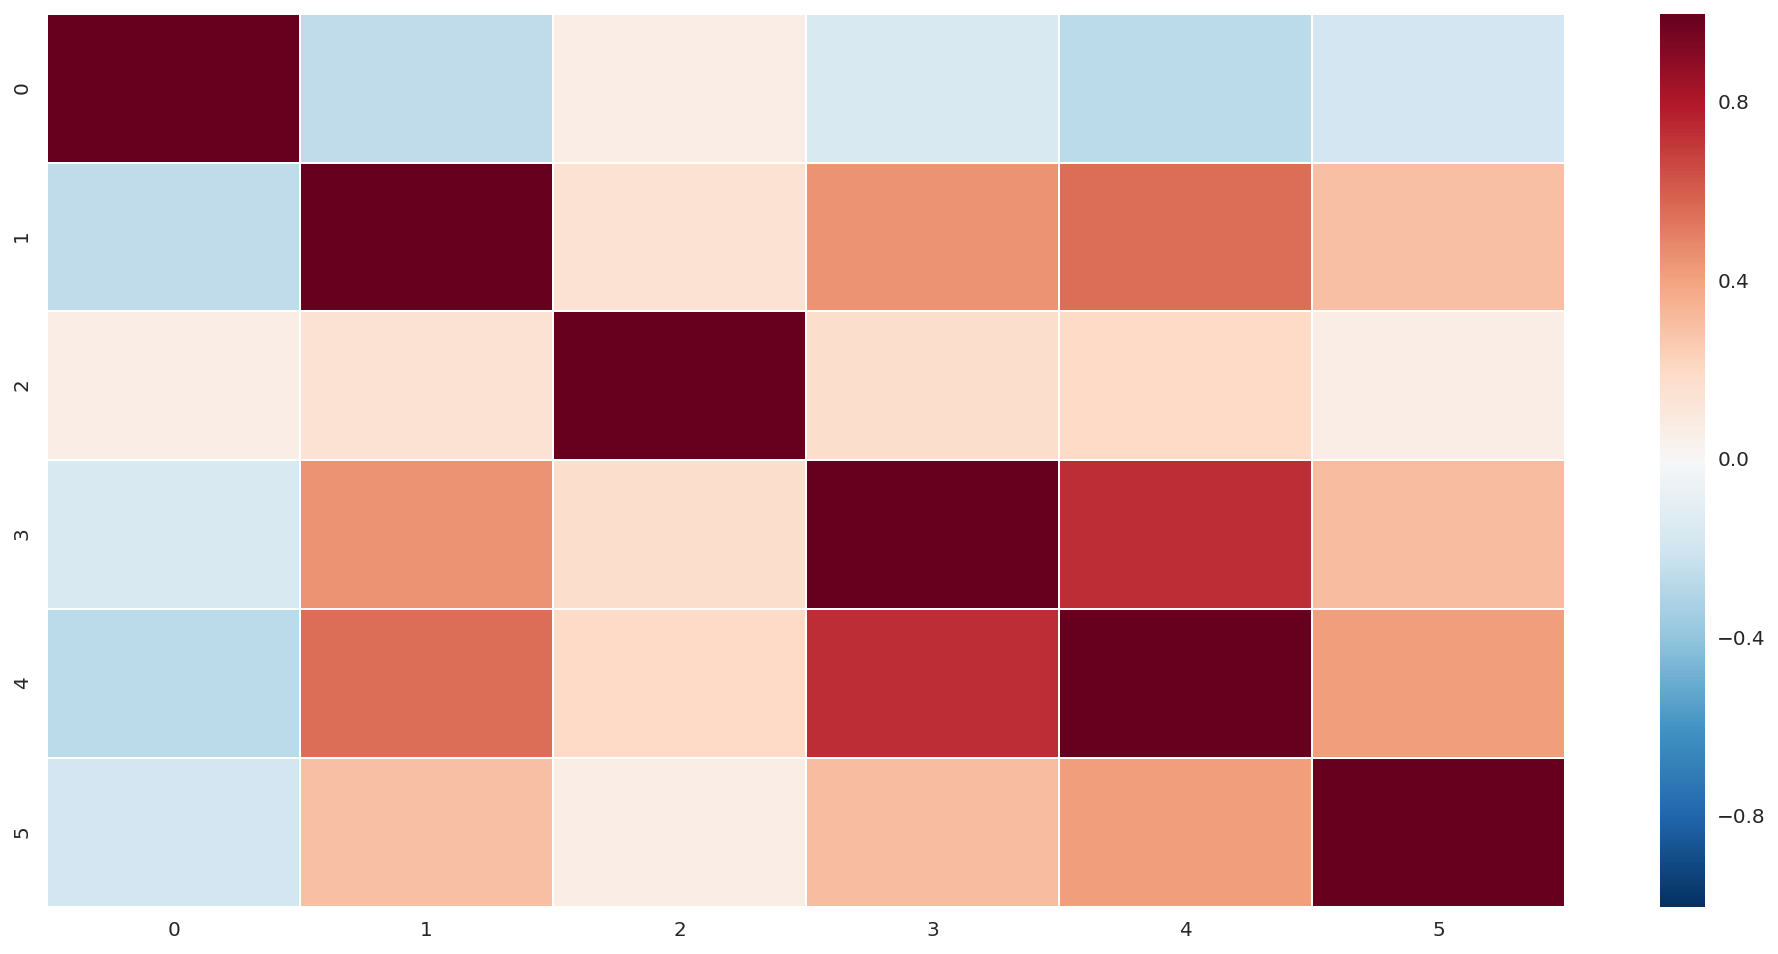

In [43]:
sns.heatmap(sp_corr);

In this case we're repeating earlier results. For convenenience, we can also show multiple graphs side-by-side.

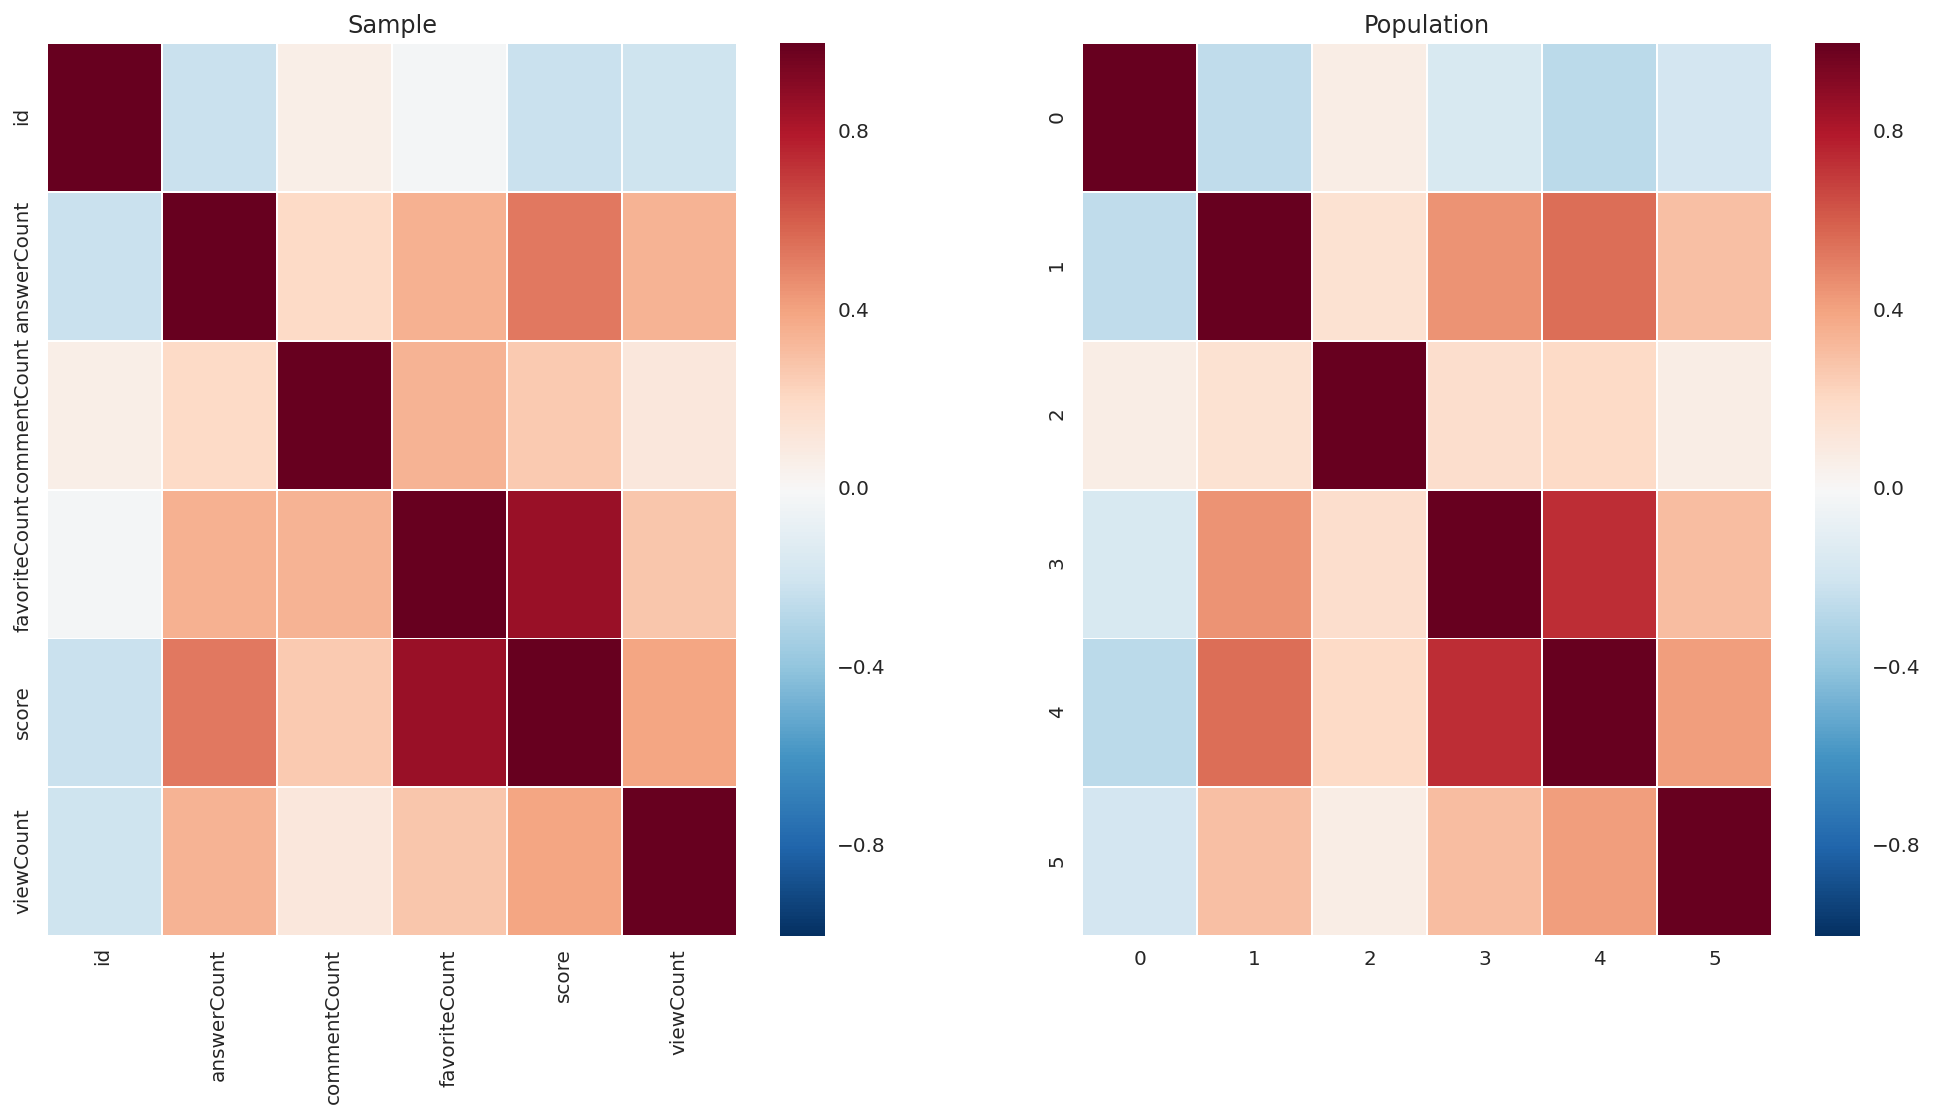

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Sample")
ax2.set_title("Population")
sns.heatmap(pf_corr, ax=ax1)
sns.heatmap(sp_corr, ax=ax2);

## Phase 4: Beyond Basic Attributes

So far we have only looked at simple attributes that already exist in the data. To find more relationships, it's normally necessary to start deriving attributes and looking for relationships there.

As a simple example, we can assume that votes will accumulate over time. There are two reasonable hypotheses here:

1. Posts will keep accumulating votes at a certain rate forever.
2. Posts will accumulate votes over time, but they will taper off.

So let's have a look at the scores of questions graphed against their age…

In [45]:
from datetime import datetime

now = datetime.now()
def withAge(row):
    return Row(id = row.id,
               age = (now - row.created).total_seconds(),
               score = row.score)

questionScores = questions.select('id', 'created', 'score')
fraction = 1000.0 / questionScores.count()
questionScoreSamples = questionScores.sample(fraction=fraction, withReplacement=False, seed=123456) \
                                     .map(withAge)

In [46]:
questionScoresPf = sql.createDataFrame(questionScoreSamples).toPandas()

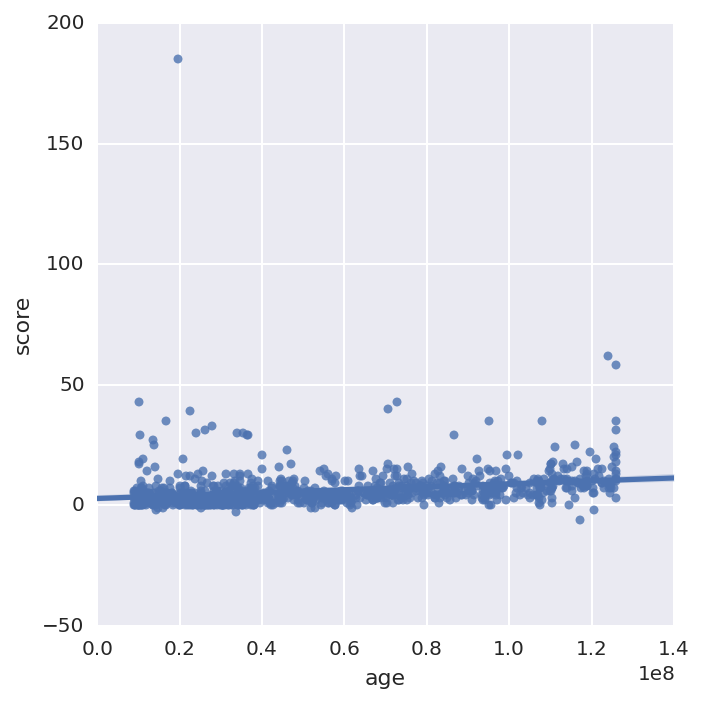

In [47]:
sns.lmplot(x="age", y="score", data=questionScoresPf);

This looks like a good correlation, right?

Well, maybe not:

In [48]:
questionScoresPf.corr()

,age,id,score
age,1.000000,-0.981526,0.241694
id,-0.981526,1.000000,-0.220372
score,0.241694,-0.220372,1.000000


In [49]:
Statistics.corr(questionScores.rdd.map(lambda row: [row.id, (now - row.created).total_seconds(), row.score]))

array([[ 1.        , -0.98148365, -0.27043911],
       [-0.98148365,  1.        ,  0.28638077],
       [-0.27043911,  0.28638077,  1.        ]])

Bummer.

However, it turns out what we doing was probably wrong. If we think about it, we're looking at the total scores for each question here. These obviously vary, and in the global sense aren't related to the age at all. Our original hypothesis was that for an individual question it would vary with time.

## Phase 5: Switching to StackOverflow

So far we've only been looking at a small dataset, but we can run the same analysis on the complete StackOverflow dataset. This dataset is much larger.

In [50]:
so_files = ["/stackexchange/stackoverflow.com/posts/part-r-%05d.parquet" % x for x in range(1,64)]
so_posts = sql.parquetFile(*so_files)
so_questions = so_posts.filter(so_posts.postType == 1)
so_answers = so_posts.filter(so_posts.postType == 2)
(so_questions.count(), so_answers.count(), so_posts.count())

(7990787L, 13684117L, 21736594L)

How big was the first dataset again?

In [51]:
(questions.count(), answers.count(), posts.count())

(10509L, 18991L, 32259L)

Right, so we're a factor of ~673 larger. This is why it was important to get things fast with the smaller dataset; anything taking even 10 seconds on the small dataset would now take a few hours otherwise.

So let's revisit the answer counts and see if they look similar.

In [52]:
so_answerCounts = so_questions.select('answerCount').rdd.map(lambda row: row.answerCount).countByValue()
so_answerCounts

defaultdict(<type 'int'>, {0: 921222, 1: 3604145, 2: 1892953, 3: 845937, 4: 375446, 5: 170768, 6: 80577, 7: 40283, 8: 21433, 9: 12123, 10: 7502, 11: 4757, 12: 3385, 13: 2332, 14: 1736, 15: 1204, 16: 927, 17: 724, 18: 545, 19: 473, 20: 348, 21: 279, 22: 237, 23: 209, 24: 162, 25: 140, 26: 110, 27: 92, 28: 82, 29: 65, 30: 57, 31: 64, 32: 47, 33: 43, 34: 34, 35: 34, 36: 30, 37: 27, 38: 18, 39: 15, 40: 16, 41: 15, 42: 9, 43: 13, 44: 7, 45: 13, 46: 8, 47: 5, 48: 6, 49: 6, 50: 5, 51: 8, 52: 4, 53: 5, 54: 3, 55: 6, 56: 5, 57: 2, 58: 1, 59: 2, 60: 3, 61: 3, 62: 3, 63: 1, 64: 2, 65: 3, 66: 1, 67: 1, 68: 2, 69: 1, 70: 1, 71: 4, 72: 3, 73: 3, 74: 1, 78: 6, 80: 1, 83: 1, 84: 1, 86: 1, 87: 3, 89: 1, 90: 1, 91: 1, 93: 2, 97: 1, 99: 1, 100: 3, 101: 2, 103: 1, 105: 1, 106: 1, 112: 1, 114: 1, 116: 1, 122: 1, 124: 1, 129: 3, 131: 1, 136: 1, 150: 1, 163: 1, 176: 1, 191: 1, 193: 1, 195: 1, 518: 1, 213: 1, 296: 1, 316: 1, 320: 1, 408: 1, 459: 1})

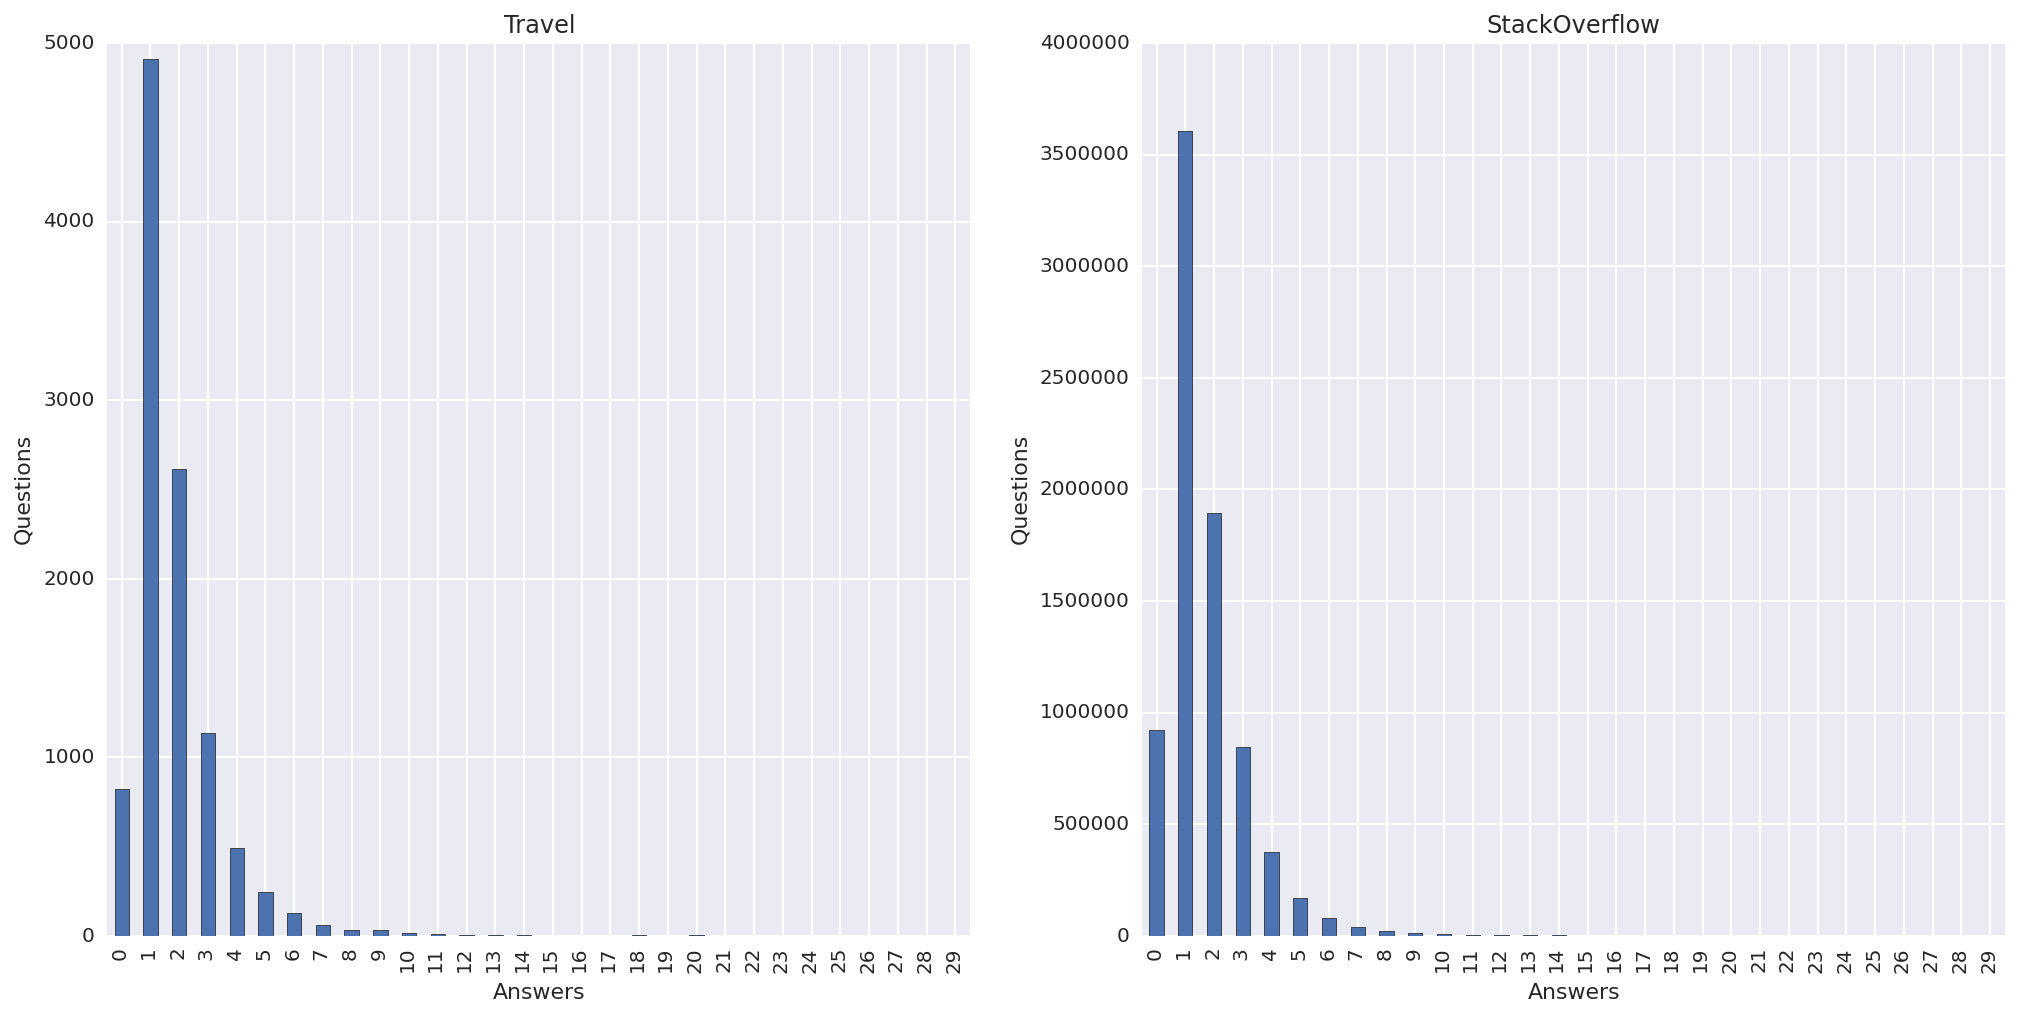

In [53]:
def sideplot(sharey=False):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=sharey)
    ax1.set_title("Travel")
    ax2.set_title("StackOverflow")
    return (ax1, ax2)

(ax1, ax2) = sideplot()
pd.Series(answerCounts, index=np.arange(30)).fillna(0).plot(kind='bar', ax=ax1);
pd.Series(so_answerCounts, index=np.arange(30)).fillna(0).plot(kind='bar', ax=ax2);
labels("Answers", "Questions", ax1, ax2)

The curve looks roughly the same, which is nice. Although if you look carefully the ratio of unanswered questions is slightly higher. (We could explore this further by normalizing both and plotting on the same graph.)

Now let's revisit the site traffic trends once more.

In [54]:
so_askedTimestamps = so_questions.select("created")
so_askedByMonth = so_askedTimestamps.rdd.map(lambda row: row.created.date().replace(day=1)).countByValue()
so_askedByMonth = pd.Series(so_askedByMonth)

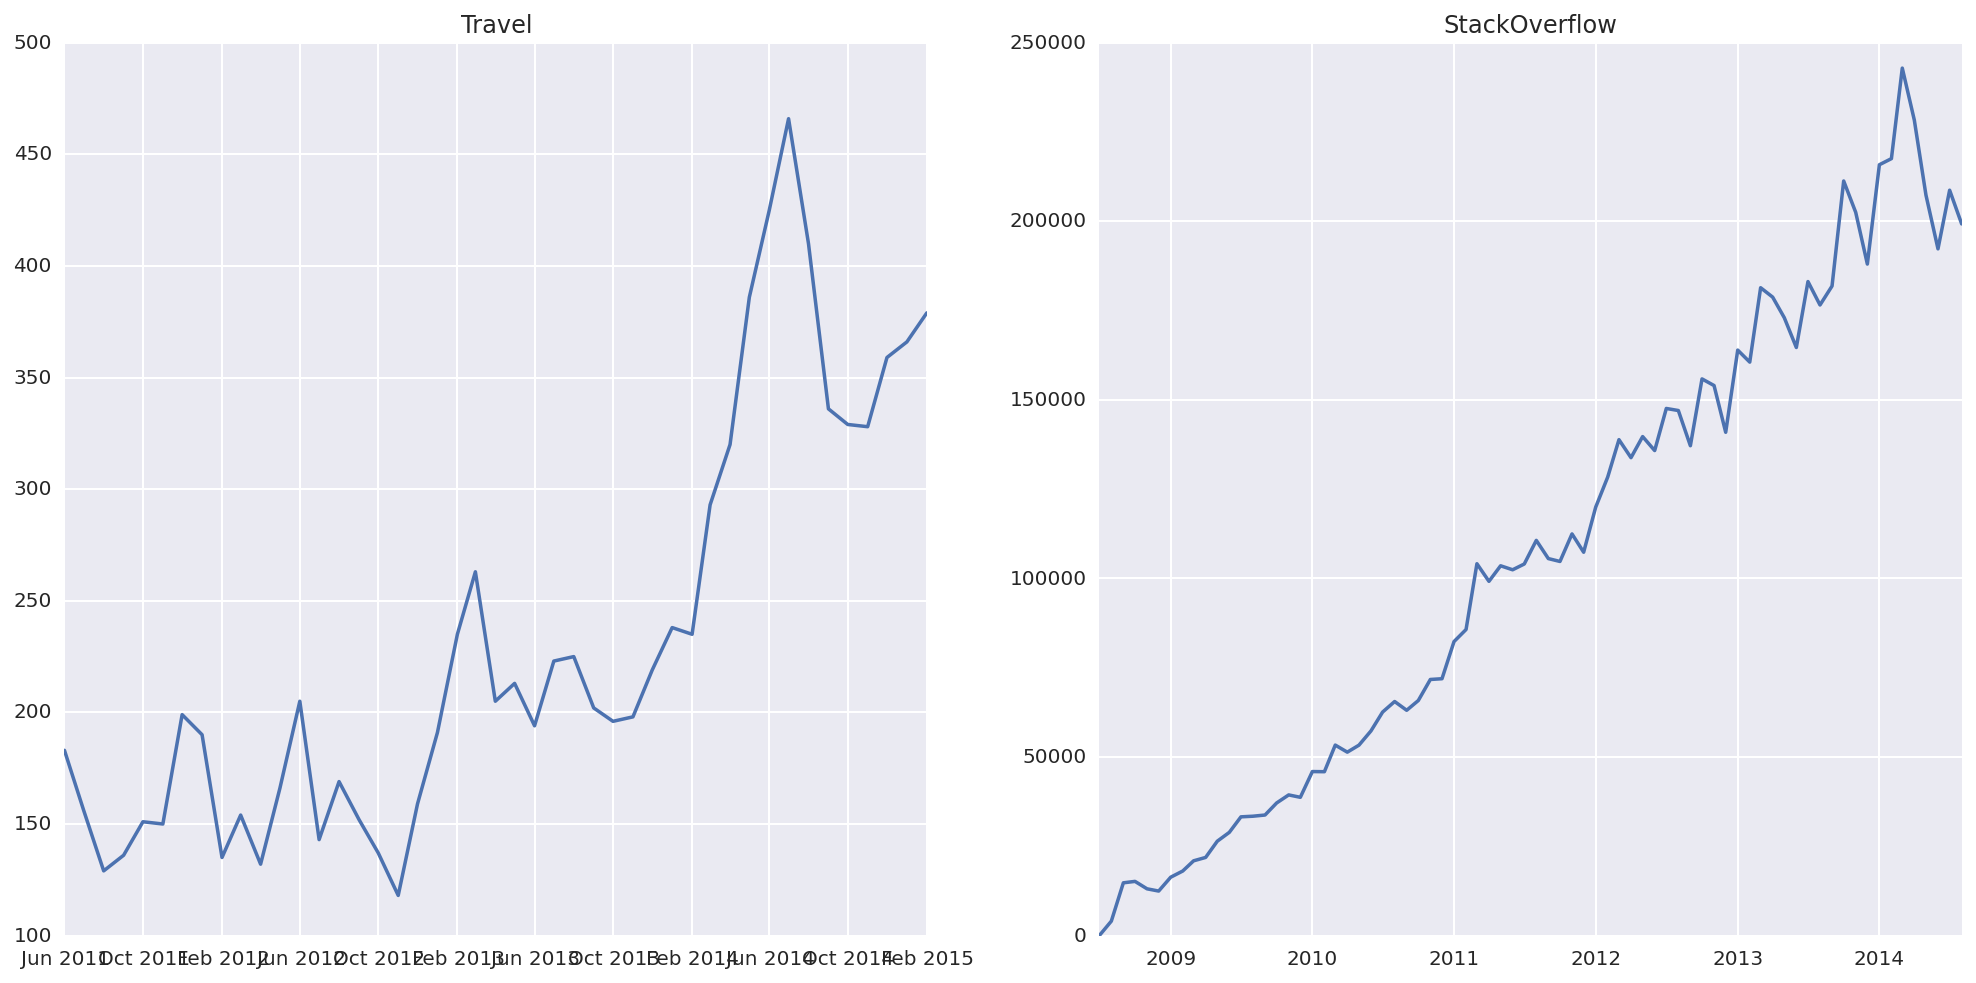

In [55]:
(ax1, ax2) = sideplot()
askedByMonth[:-1].plot(ax=ax1);
so_askedByMonth[:-1].plot(ax=ax2);

Not much to see here. Obviously we have a longer history, and the volume is much higher.

And by day of week?

In [56]:
so_askedByDoW = so_askedTimestamps.map(lambda row: row.created.isoweekday()).countByValue()
so_askedByDoW = pd.Series(so_askedByDoW)

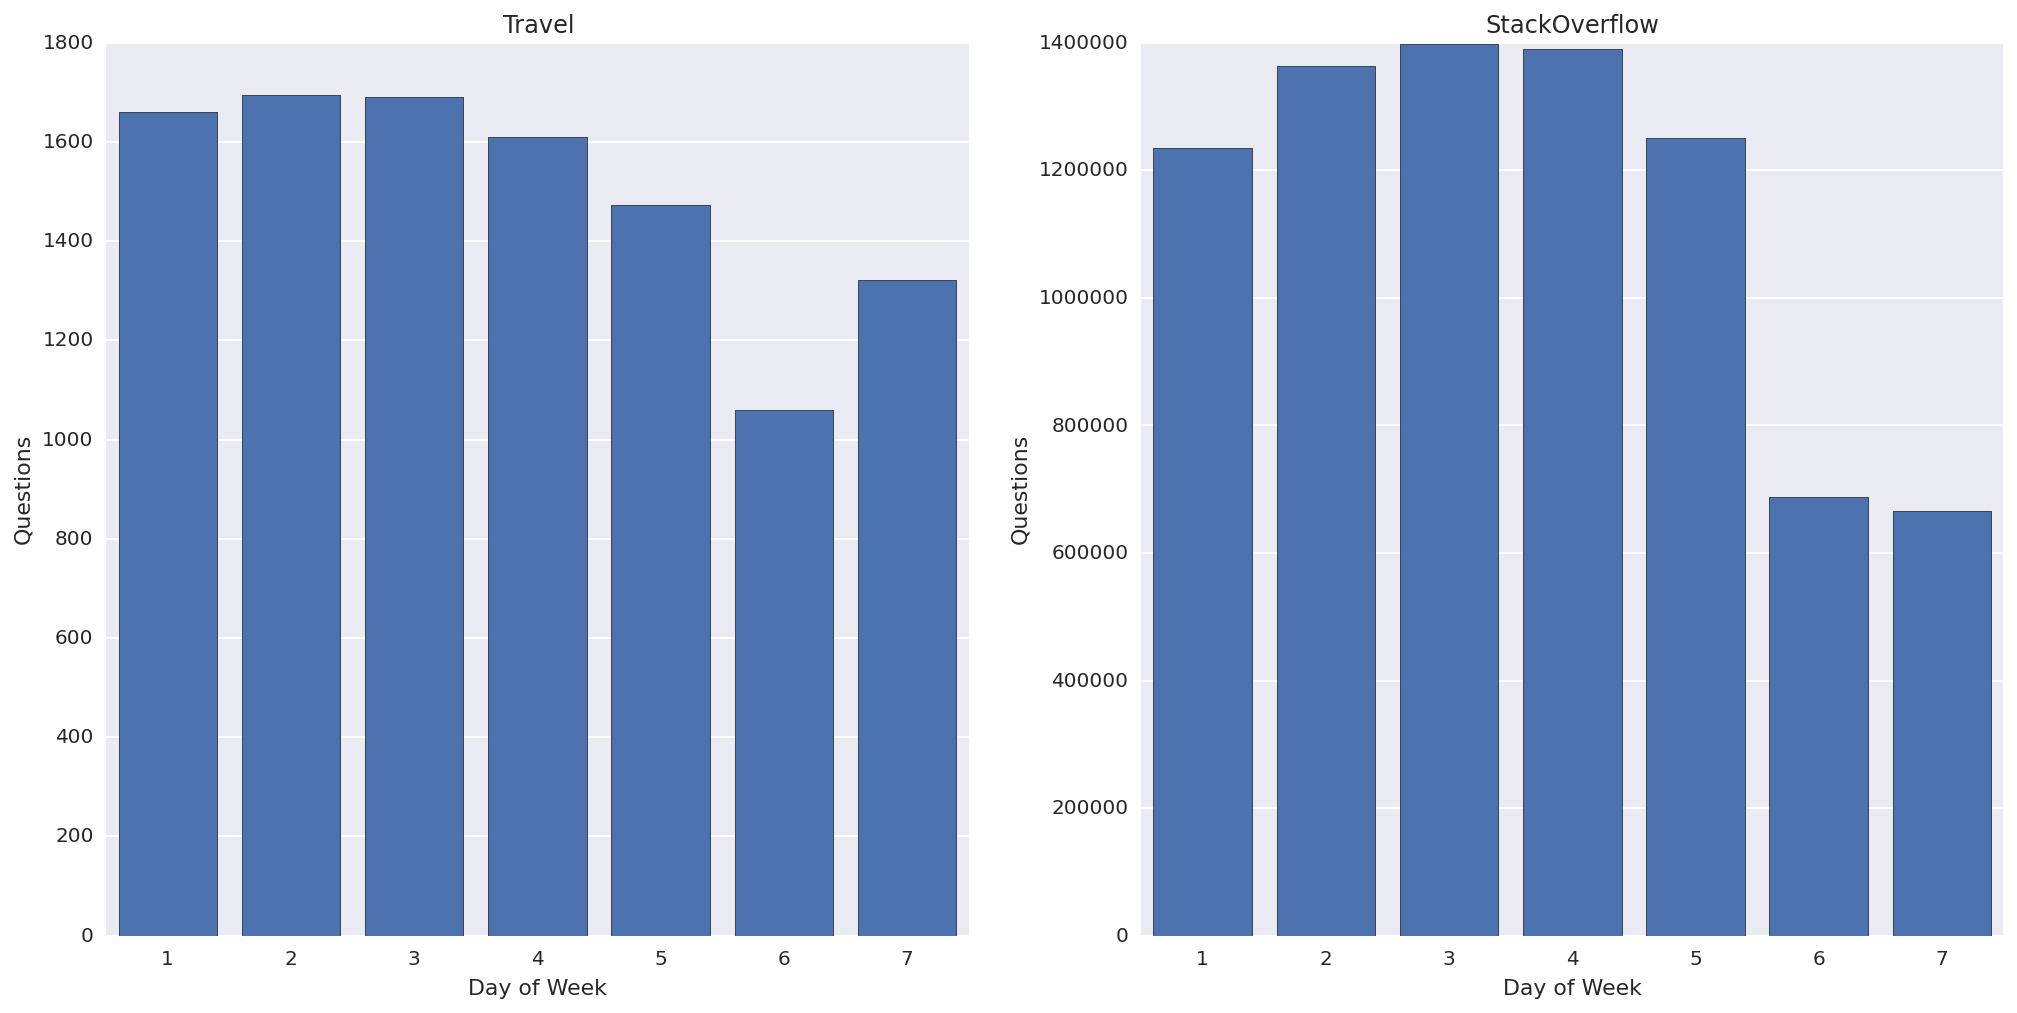

In [57]:
(ax1, ax2) = sideplot()
sns.barplot(askedByDoW.index, y=askedByDoW, ax=ax1)
sns.barplot(so_askedByDoW.index, y=so_askedByDoW, ax=ax2)
labels("Day of Week", "Questions", ax1, ax2)

Oooh.

Aside from the scale, there's also clearly more difference between weekdays and weekends.

Let's quickly look once more at how many questions are answered, and quickly, according to the day they were asked.

In [58]:
so_closedByDoW = so_questions.filter("closed is not null") \
                             .select("closed") \
                             .map(lambda row: row.closed.isoweekday ()) \
                             .countByValue()
so_closedByDoW = pd.Series(so_closedByDoW)

In [59]:
so_questionsByDoW = pd.DataFrame({"asked": so_askedByDoW, "closed": so_closedByDoW})
so_questionsByDoW["pSuccess"] = so_questionsByDoW["closed"] / so_questionsByDoW["asked"]

In [60]:
so_quicklyByDoW = so_questions.filter("closed is not null") \
                              .select("created", "closed") \
                              .rdd.filter(lambda row: (row.closed - row.created).days < 1) \
                              .map(lambda row: row.created.isoweekday()) \
                              .countByValue()
so_questionsByDoW["quickly"] = pd.Series(so_quicklyByDoW)
so_questionsByDoW["pQuickly"] = so_questionsByDoW["quickly"] / so_questionsByDoW["asked"]
so_questionsByDoW

,asked,closed,pSuccess,quickly,pQuickly
1,1234719,56297,0.045595,35446,0.028708
2,1364195,58107,0.042594,37904,0.027785
3,1397820,57340,0.041021,36996,0.026467
4,1389828,55573,0.039986,35885,0.025820
5,1250536,55124,0.044080,33534,0.026816
6,688023,37877,0.055052,20855,0.030311
7,665666,36250,0.054457,21990,0.033035


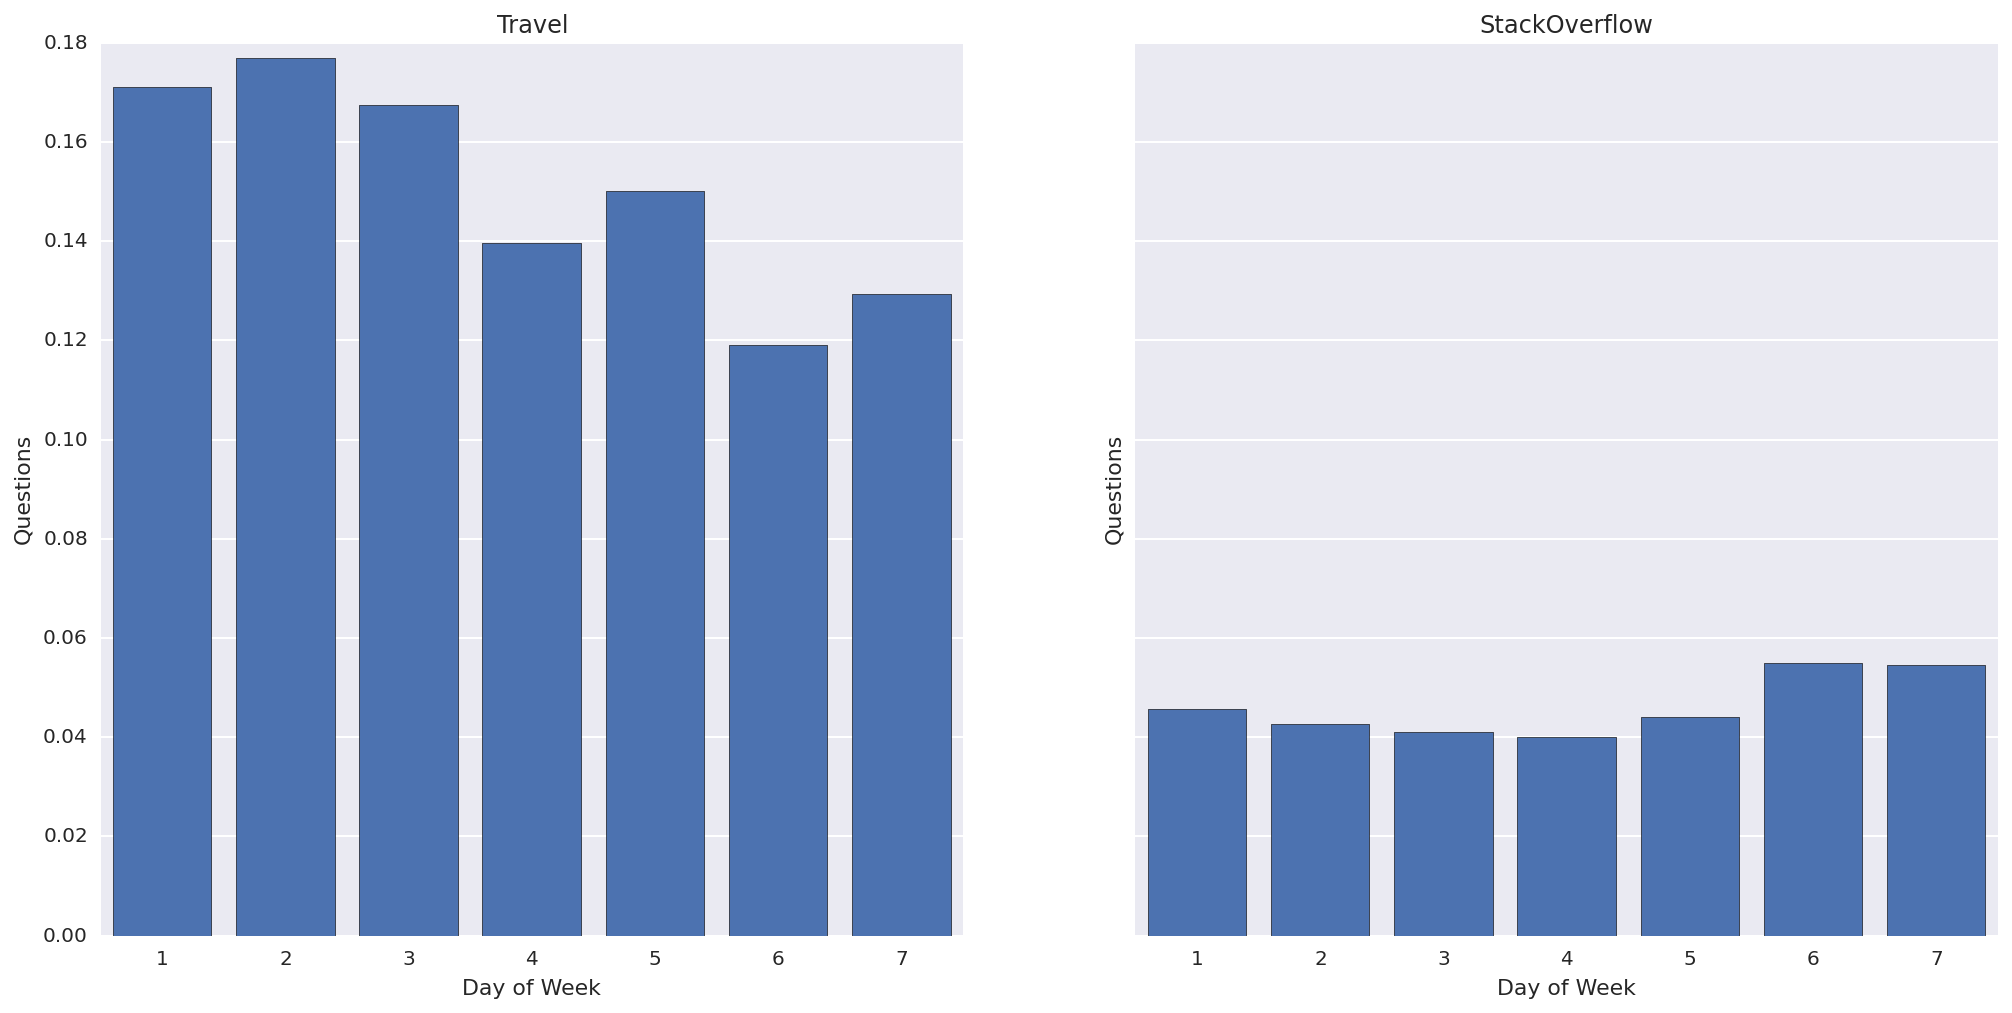

In [61]:
(ax1, ax2) = sideplot(sharey=True)
sns.barplot(questionsByDoW.index, y="pSuccess", data=questionsByDoW, ax=ax1)
sns.barplot(so_questionsByDoW.index, y="pSuccess", data=so_questionsByDoW, ax=ax2)
labels("Day of Week", "Questions", ax1, ax2)

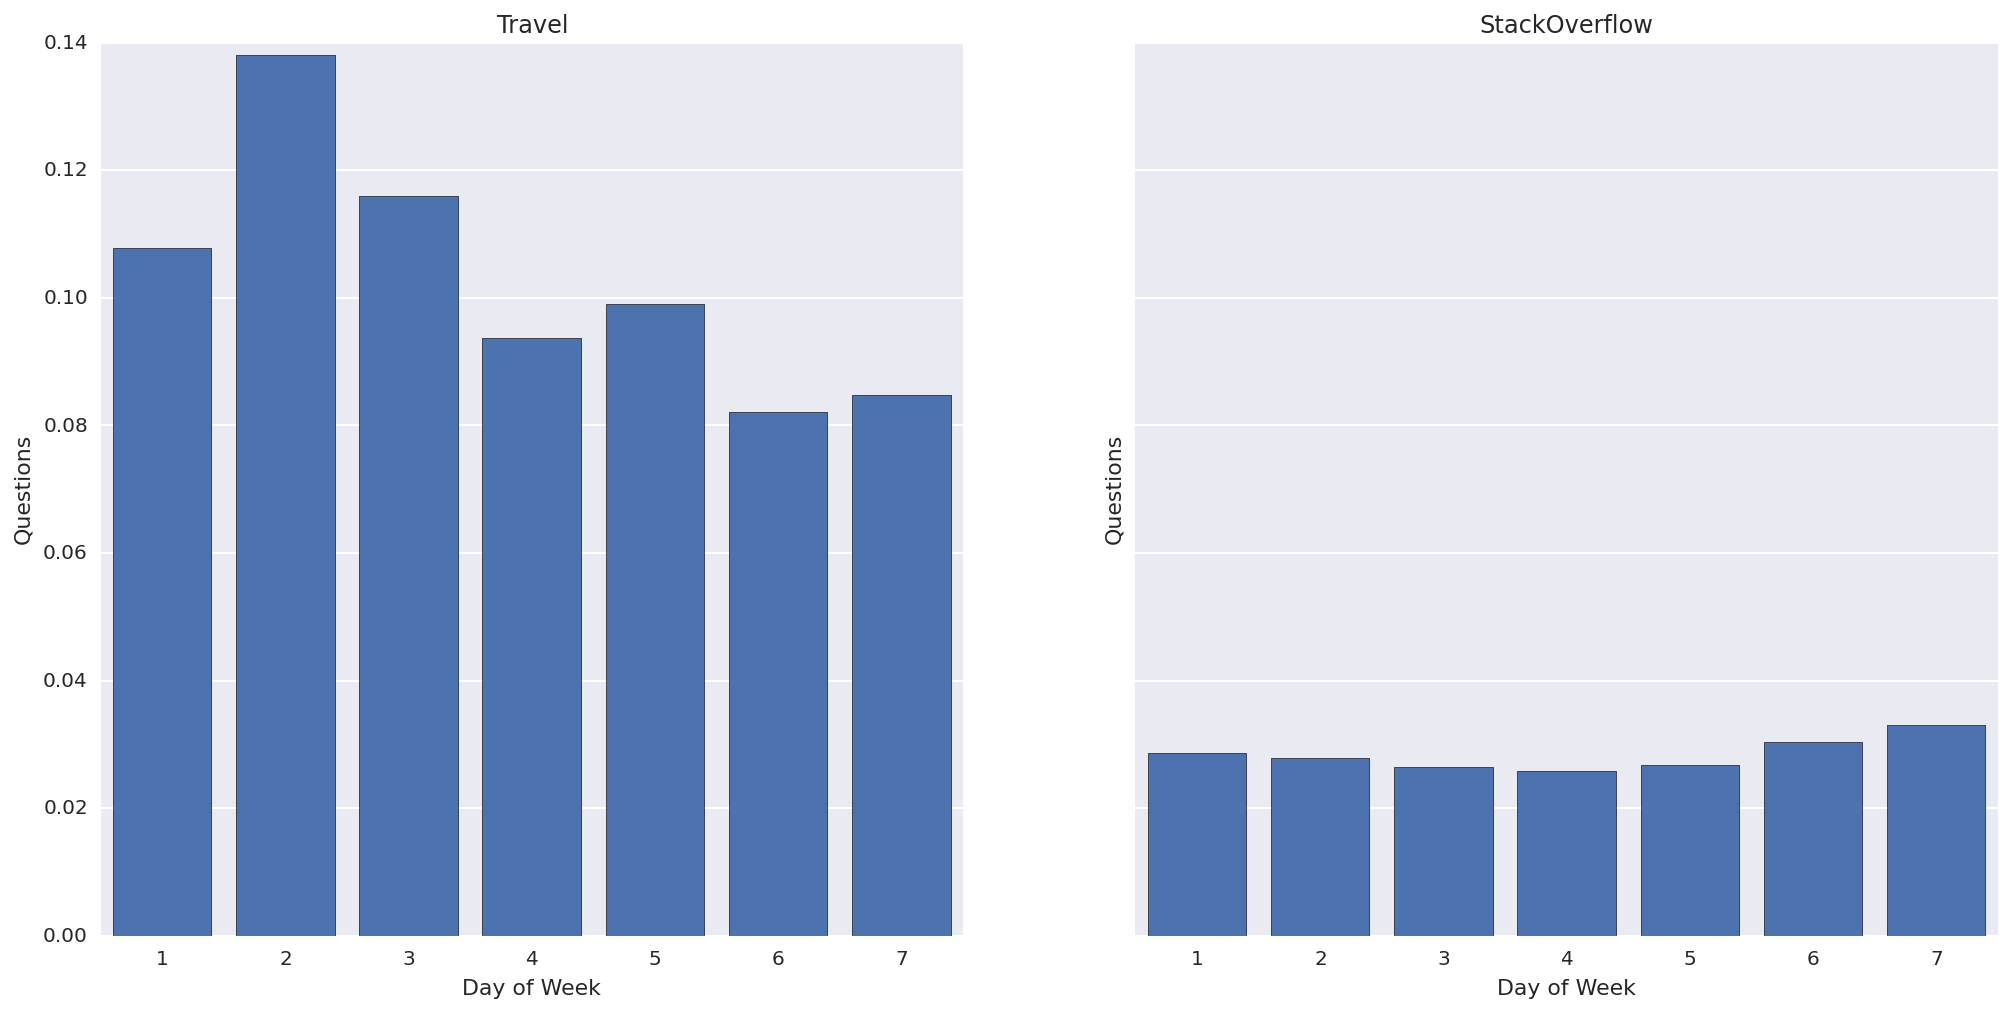

In [62]:
(ax1, ax2) = sideplot(sharey=True)
sns.barplot(questionsByDoW.index, y="pQuickly", label="DoW", data=questionsByDoW, ax=ax1)
sns.barplot(so_questionsByDoW.index, y="pQuickly", data=so_questionsByDoW, ax=ax2)
labels("Day of Week", "Questions", ax1, ax2)

So… things are fairly different here. Most obvious, is that questions are less likely to be answered on StackOverflow than on the travel site.

However there's also some variation in the distribution over the week. In particular, questions on the weekend do better with StackOverflow, and in particular it seems that questions on a Sunday are more likely to have an answer within a day.

Now let's move on to the correlations. Once again it makes sense to only work on a sample. Rather than display all the plots, we'll go straight to the correlation matrix.

In [63]:
so_questionCounts = so_questions.select('id','answerCount','commentCount','favoriteCount','score','viewCount')
fraction = 100000.0 / so_questionCounts.count()
so_pf = so_questionCounts.sample(fraction=fraction, withReplacement=False, seed=123456).toPandas()
so_pf_corr = so_pf.corr(method='pearson')
so_pf_corr

,id,answerCount,commentCount,favoriteCount,score,viewCount
id,1.000000,-0.268953,0.108610,-0.042790,-0.084992,-0.187625
answerCount,-0.268953,1.000000,0.042408,0.191466,0.187973,0.282977
commentCount,0.108610,0.042408,1.000000,0.008267,0.009431,-0.004903
favoriteCount,-0.042790,0.191466,0.008267,1.000000,0.928802,0.521611
score,-0.084992,0.187973,0.009431,0.928802,1.000000,0.685480
viewCount,-0.187625,0.282977,-0.004903,0.521611,0.685480,1.000000


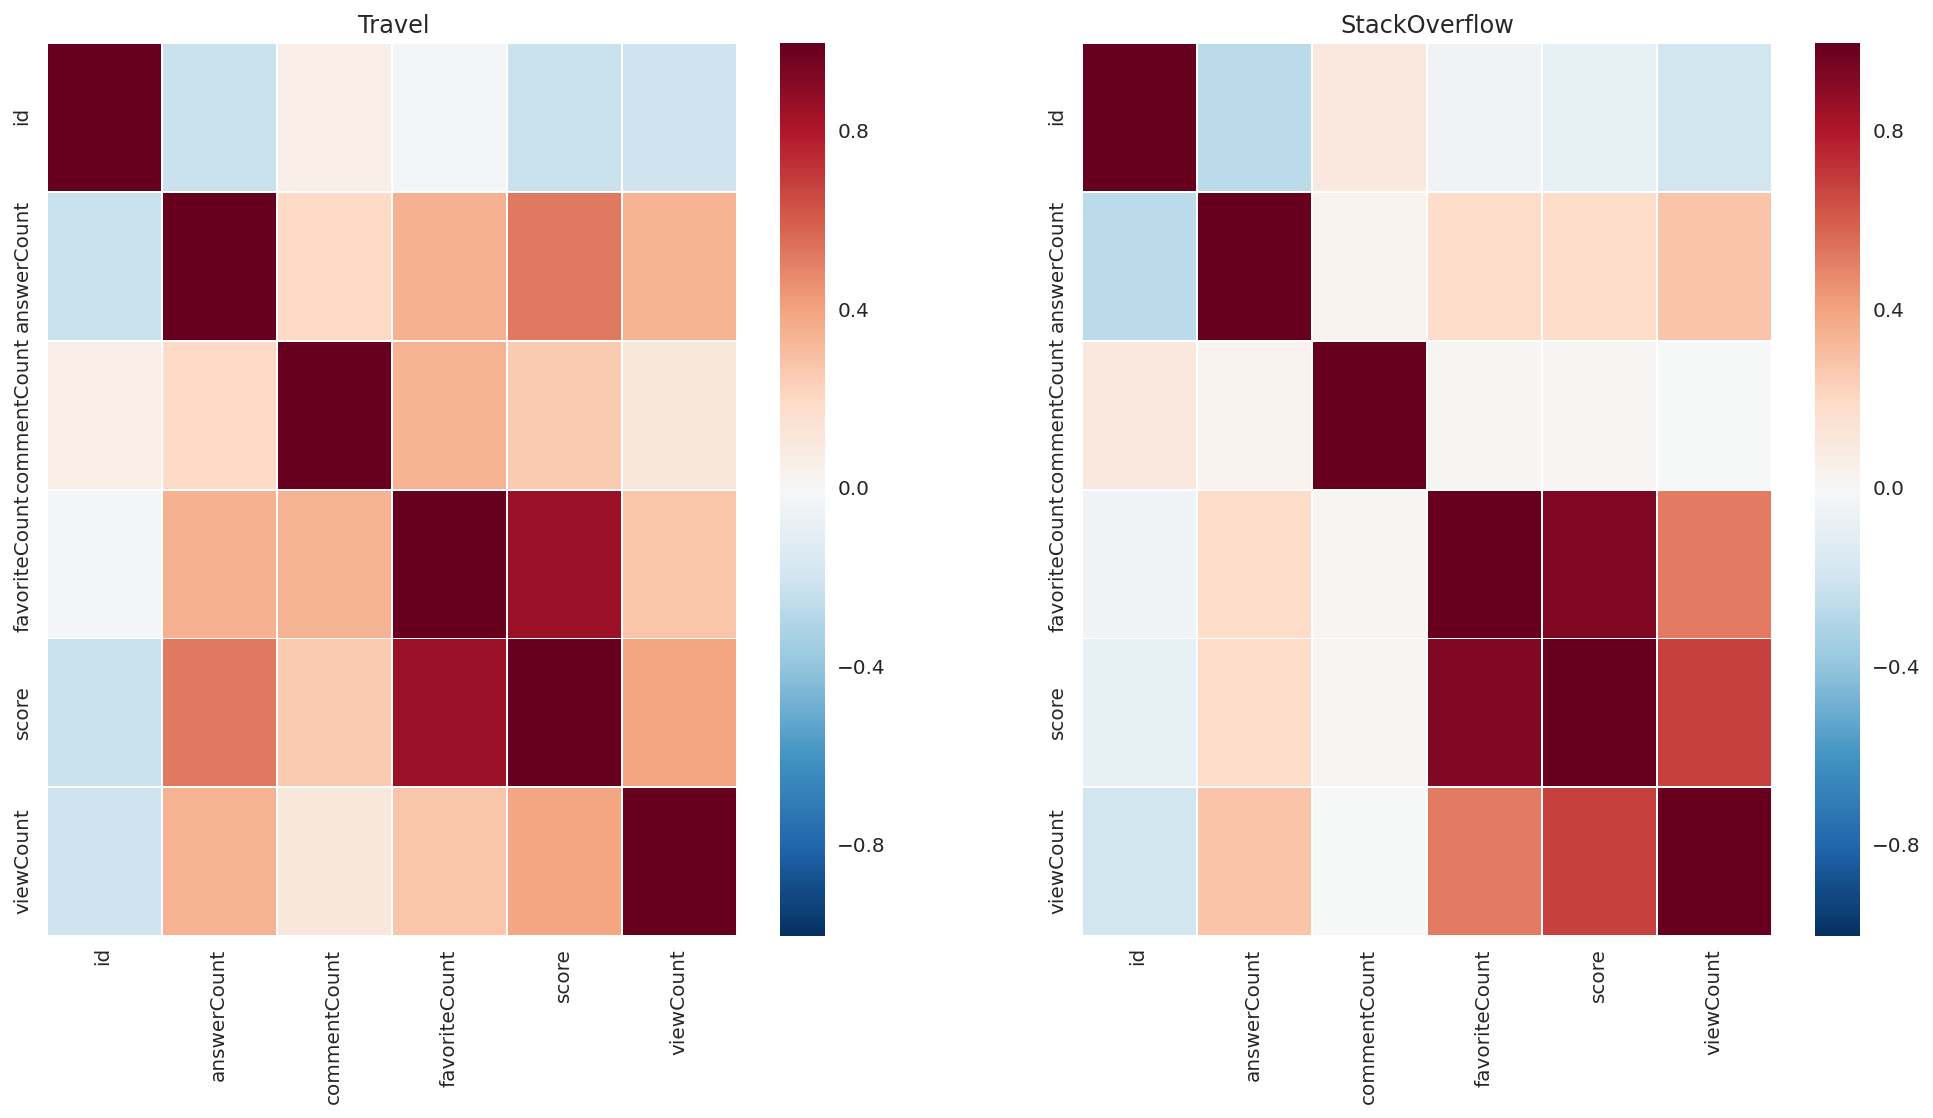

In [64]:
(ax1, ax2) = sideplot()
sns.heatmap(pf_corr, ax=ax1)
sns.heatmap(so_pf_corr, ax=ax2);

Ahh. These are different: in addition to the relationship between score and favorite-count, there's an additional correlation between the view and favourite counts. Let's plot these…

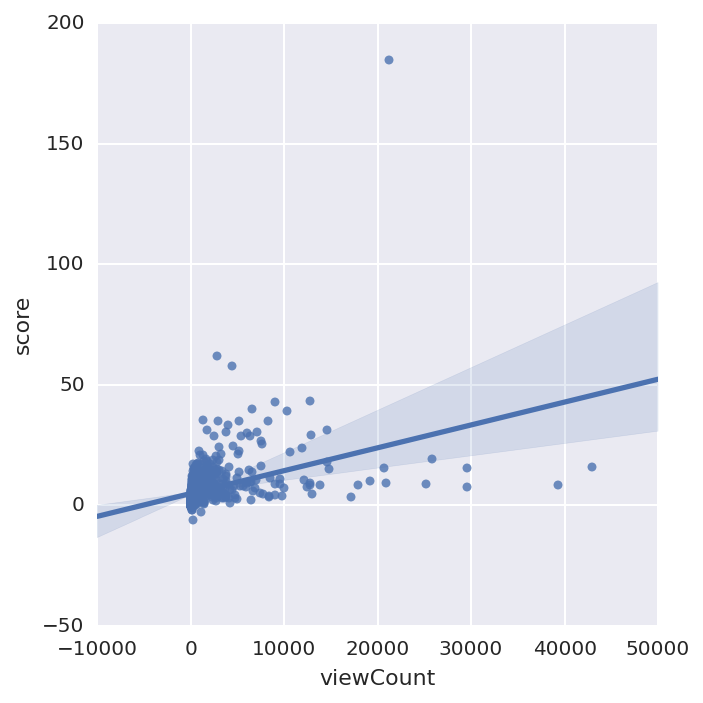

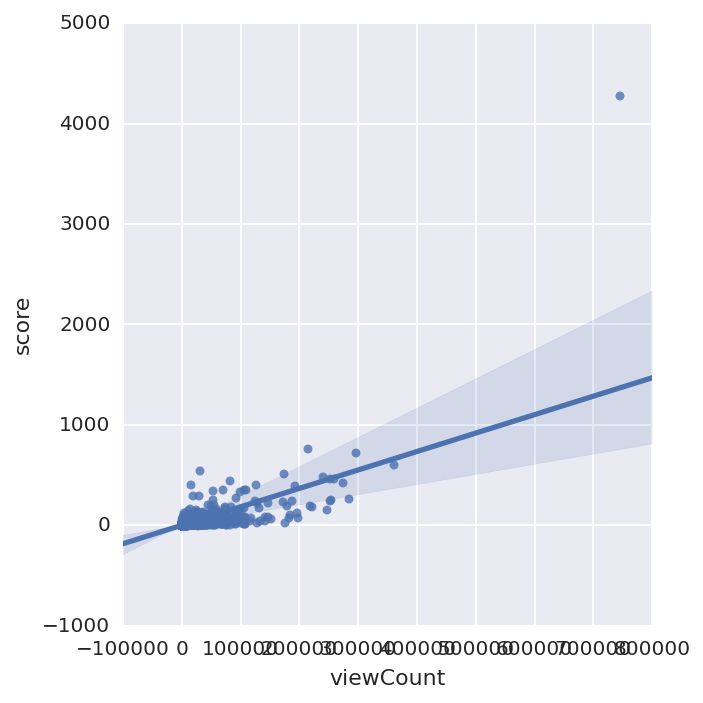

In [65]:
sns.lmplot(x='viewCount', y='score', data=pf, y_jitter=0.4);
sns.lmplot(x='viewCount', y='score', data=so_pf, y_jitter=0.4);

These graphs don't really show the correlation clearly, mainly due to the outliers and the number of points. (Also note that statisticians will immediately want to look at other things, such as the distribution of points around the regression line, before deciding there's really a correlation.)